In [1]:
import omegaqe
from omegaqe.powerspectra import Powerspectra
from omegaqe.modecoupling import Modecoupling
import omegaqe.postborn as postborn
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.offsetbox import AnchoredText
from omegaqe.cosmology import Cosmology
import numpy as np
from omegaqe.noise import Noise
from omegaqe.fisher import Fisher
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy import stats

In [2]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.rcParams['xtick.major.pad']='8'
plt.rc('figure', facecolor='w')

In [3]:
power = Powerspectra()
cosmo = Cosmology()
fisher = Fisher()
fisher.setup_bispectra()
_noise = fisher.covariance.noise
results_dir = omegaqe.RESULTS_DIR

In [4]:
omega_Ls, omega_ps = cosmo.get_postborn_omega_ps(ellmax=8000)
my_omega_ps = postborn.omega_ps(omega_Ls)
my_gal_omega_ps = postborn.omega_ps(omega_Ls, cmb=False)

In [5]:
class Exp():
    def __init__(self):
        self.counter = 0
        self.exps = {}
        self.colours = []
        self.labels = []
    def add_exp(self, name, colour, label):
        self.exps[name] = self.counter
        self.colours.append(colour)
        self.labels.append(label)
        self.counter += 1
    def get_colour(self, exp):
        return self.colours[self.exps[exp]]
    def get_label(self, exp):
        return self.labels[self.exps[exp]]
    def get_exps(self):
        return self.exps.keys()

In [6]:
exps = Exp()
exps.add_exp("SO_base", u'#ff7f0e', "SO baseline")
exps.add_exp("SO_goal", u'#1f77b4', "SO goal")
exps.add_exp("S4_base", u'#2ca02c', "CMB-S4")
exps.add_exp("S4_dp", 'c', "CMB-S4 deep")


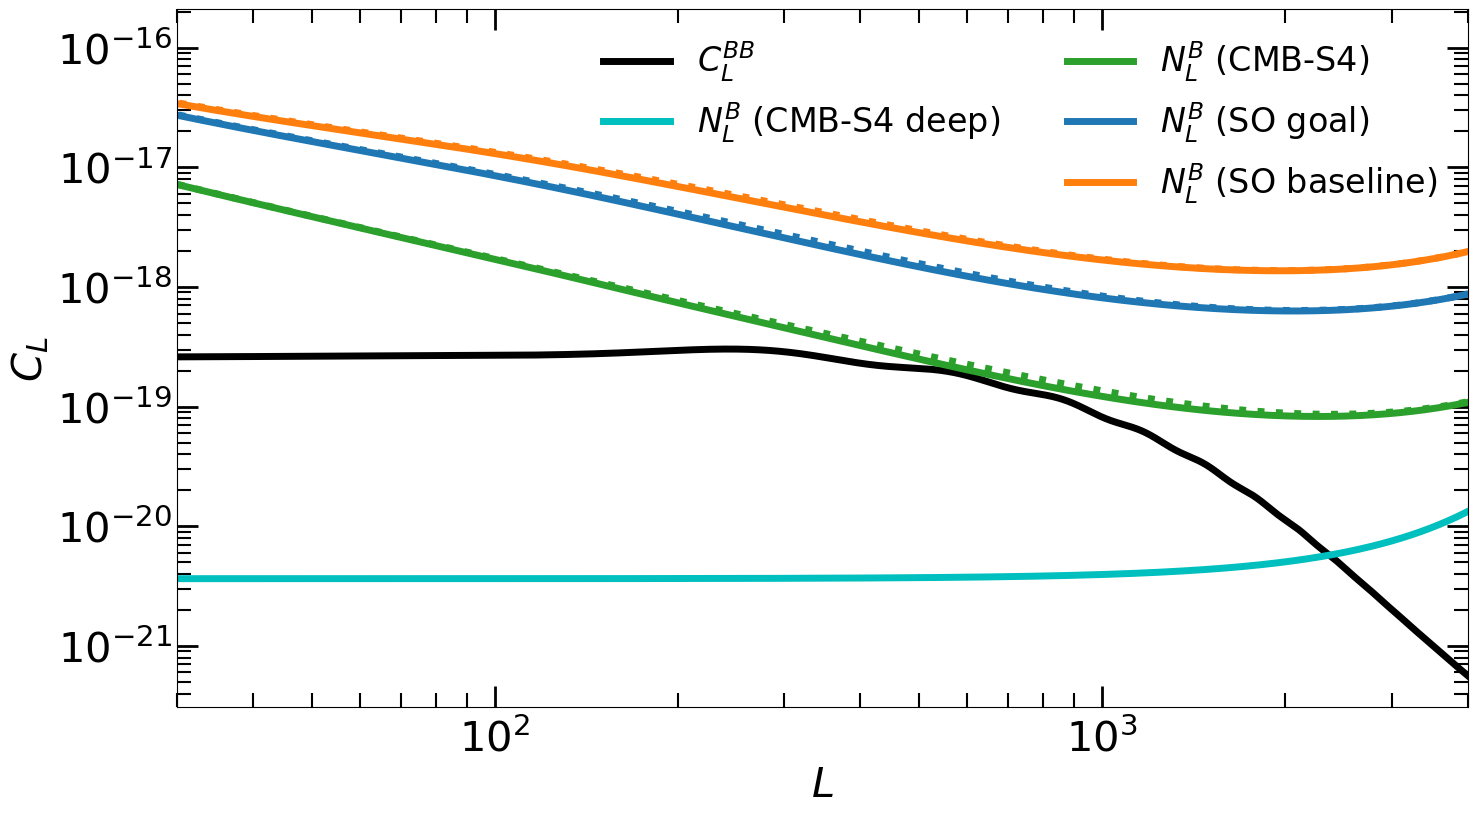

In [8]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax = 4000
ells = np.arange(2, ellmax + 1, 1)
Cl_bb = cosmo.get_lens_ps("BB")[ells]
ax.loglog(ells, Cl_bb, label="$C^{BB}_L$", linewidth=5, color="k")

deltaT, beam = _noise.get_noise_args("S4_dp")
N = _noise.get_cmb_gaussian_N("BB", deltaT, beam)[ells]
ax.loglog(ells, N, label=f"$N^B_L$ ({exps.get_label('S4_dp')})", linewidth=5, color=exps.get_colour("S4_dp"))
ax.plot([-1],[-1],label=" ", alpha=0)
exps_ = ["S4_base", "SO_goal", "SO_base"]
for exp in exps_:
    N = _noise.get_cmb_gaussian_N("BB", None,None,exp=exp)[ells]
    ax.loglog(ells, N, label=f"$N^B_L$ ({exps.get_label(exp)})", linewidth=5, color=exps.get_colour(exp))
    N = _noise.get_cmb_gaussian_N("EE", None,None,exp=exp)[ells]
    ax.loglog(ells, N, linewidth=5, color=exps.get_colour(exp), linestyle=":")


ax.legend(prop={'size': 24}, frameon=False, ncol=2)
ax.set_ylabel("$C_{L}$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
# ax.set_ylim(8e-10, 9e-7)
ax.set_xlim(30, 4e3)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

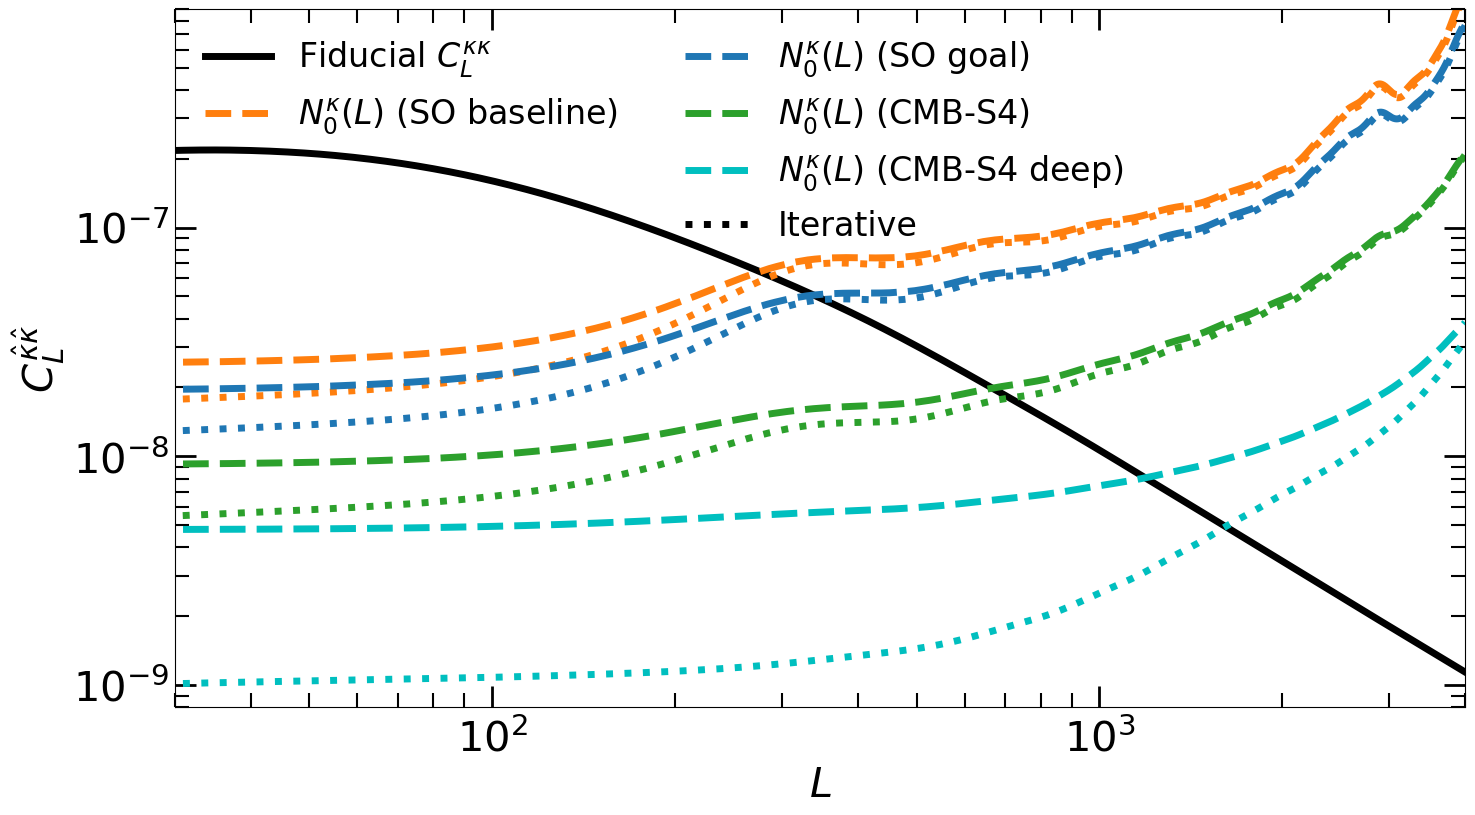

In [9]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax = 4000
ells = np.arange(2, ellmax + 1, 1)
Cl_kk = power.get_kappa_ps(ells)
ax.loglog(ells, Cl_kk, label="Fiducial $C^{\kappa\kappa}_L$", linewidth=5, color="k")

for iii, exp in enumerate(exps.get_exps()):
    
    qe = "EB" if exp=="S4_dp" else "TEB"
    _noise.setup_cmb_noise(exp=exp, qe=qe)
    N_kk = _noise.get_N0("kappa", ellmax=ellmax)
    ax.loglog(ells,N_kk[ells], linestyle="--", linewidth=5, color=exps.get_colour(exp))
    
    _noise.setup_cmb_noise(exp=exp, iter=True, qe=qe)
    N_kk = _noise.get_N0("kappa", ellmax=ellmax)
    ax.loglog(ells,N_kk[ells], linestyle=":", linewidth=5, color=exps.get_colour(exp))
    
    if iii == 1:
        ax.plot([-1],[-1], color="white", label=" ", alpha=0)
        ax.plot([-1],[-1], color="white", label=" ", alpha=0)
    
    ax.plot([-1],[-1], label="${N^{\kappa}_0(L)}$"+ f" ({exps.get_label(exp)})", color=exps.get_colour(exp), linewidth=5, linestyle="--")

    
ax.plot([-1],[-1], label="Iterative", color='k', linewidth=5, linestyle=":")


ax.legend(prop={'size': 24}, frameon=False, ncol=2, loc=2)
ax.set_ylabel("$C_{L}^{\hat{\kappa}\hat{\kappa}}$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_ylim(8e-10, 9e-7)
ax.set_xlim(30, 4e3)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)



# fig.savefig("_report_plots/kappa_ps_all.pdf", bbox_inches='tight')
plt.show()


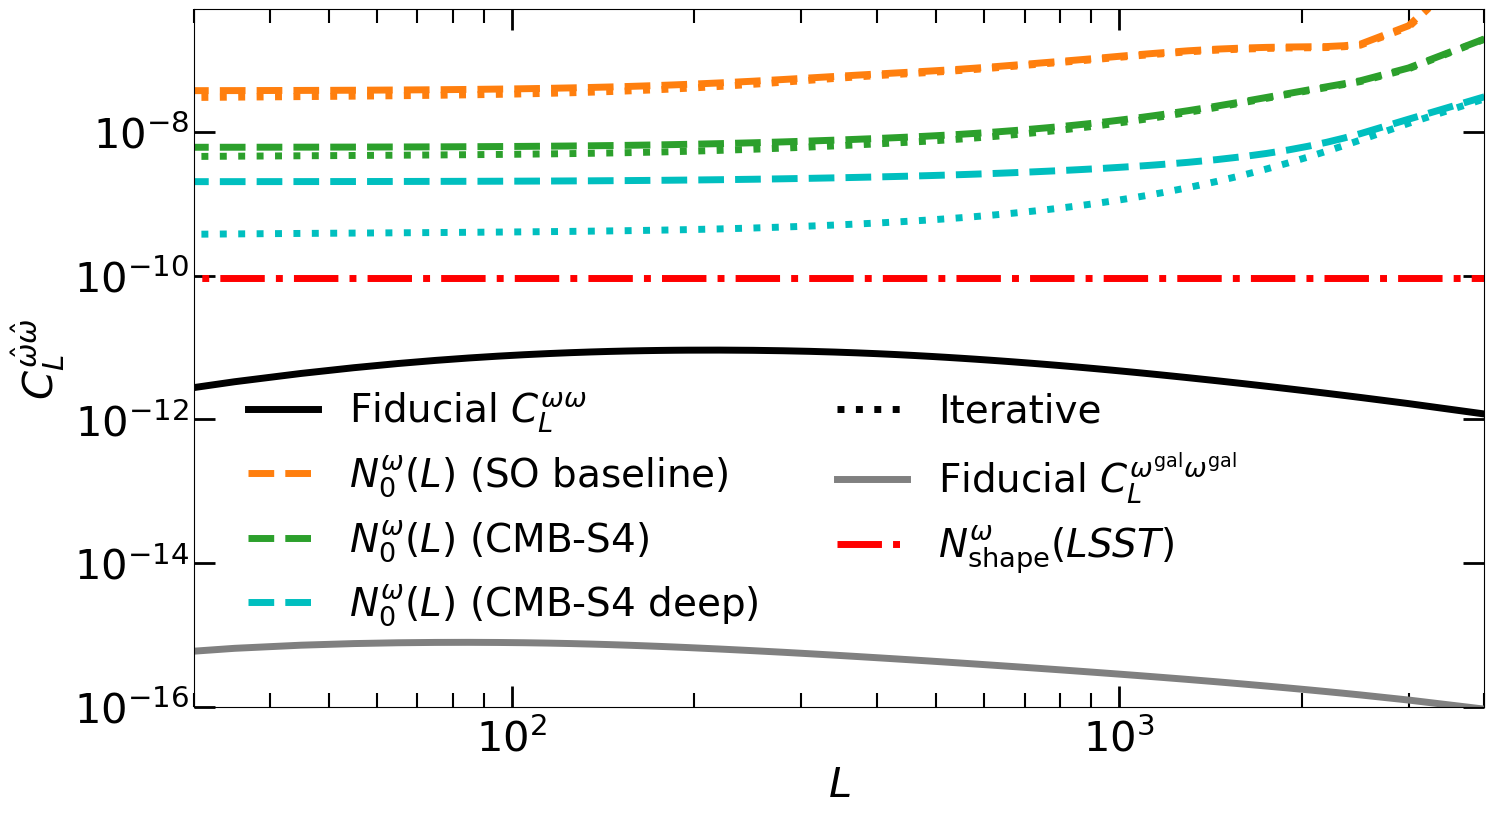

In [10]:
ellmax=4000
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.loglog(omega_Ls, my_omega_ps, label="Fiducial $C^{\omega\omega}_L$", linewidth=5, color="k")

reduced_exps = ["SO_base", "S4_base", "S4_dp"]
for iii, exp in enumerate(reduced_exps):
    
    qe = "EB" if exp=="S4_dp" else "TEB"
    
    _noise.setup_cmb_noise(exp=exp, qe=qe)
    N_ww = _noise.get_N0("omega", ellmax=ellmax)
    ax.loglog(omega_Ls,N_ww[omega_Ls], linestyle="--", label="$N^{\omega}_0(L)$" +f" ({exps.get_label(exp)})", linewidth=5, color=exps.get_colour(exp))
    
    _noise.setup_cmb_noise(exp=exp, iter=True, qe=qe)
    N_ww = _noise.get_N0("omega", ellmax=ellmax)
    ax.loglog(omega_Ls,N_ww[omega_Ls], linestyle=":", linewidth=5, color=exps.get_colour(exp))
    


    
plt.plot([-1],[-1],color="k", linestyle=":", linewidth=5, label="Iterative")
    
N_ww = _noise.get_shape_N(ellmax=ellmax)
ax.loglog(omega_Ls, my_gal_omega_ps, label="Fiducial $C^{\omega^{\mathrm{gal}}\omega^{\mathrm{gal}}}_L$", linewidth=5, color="grey")
ax.loglog(omega_Ls, N_ww[omega_Ls], label="$N^{\omega}_{\mathrm{shape}} (LSST)$", linestyle="dashdot", linewidth=5, color='r')


ax.legend(prop={'size': 28}, frameon=False, ncol=2, loc=(0.03,0.09), handlelength=1.8)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}}$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_ylim(1e-16, 5e-7)
ax.set_xlim(30, 4e3)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)


# fig.savefig("_report_plots/omega_ps_all_plus_gal.pdf", bbox_inches='tight')
plt.show()


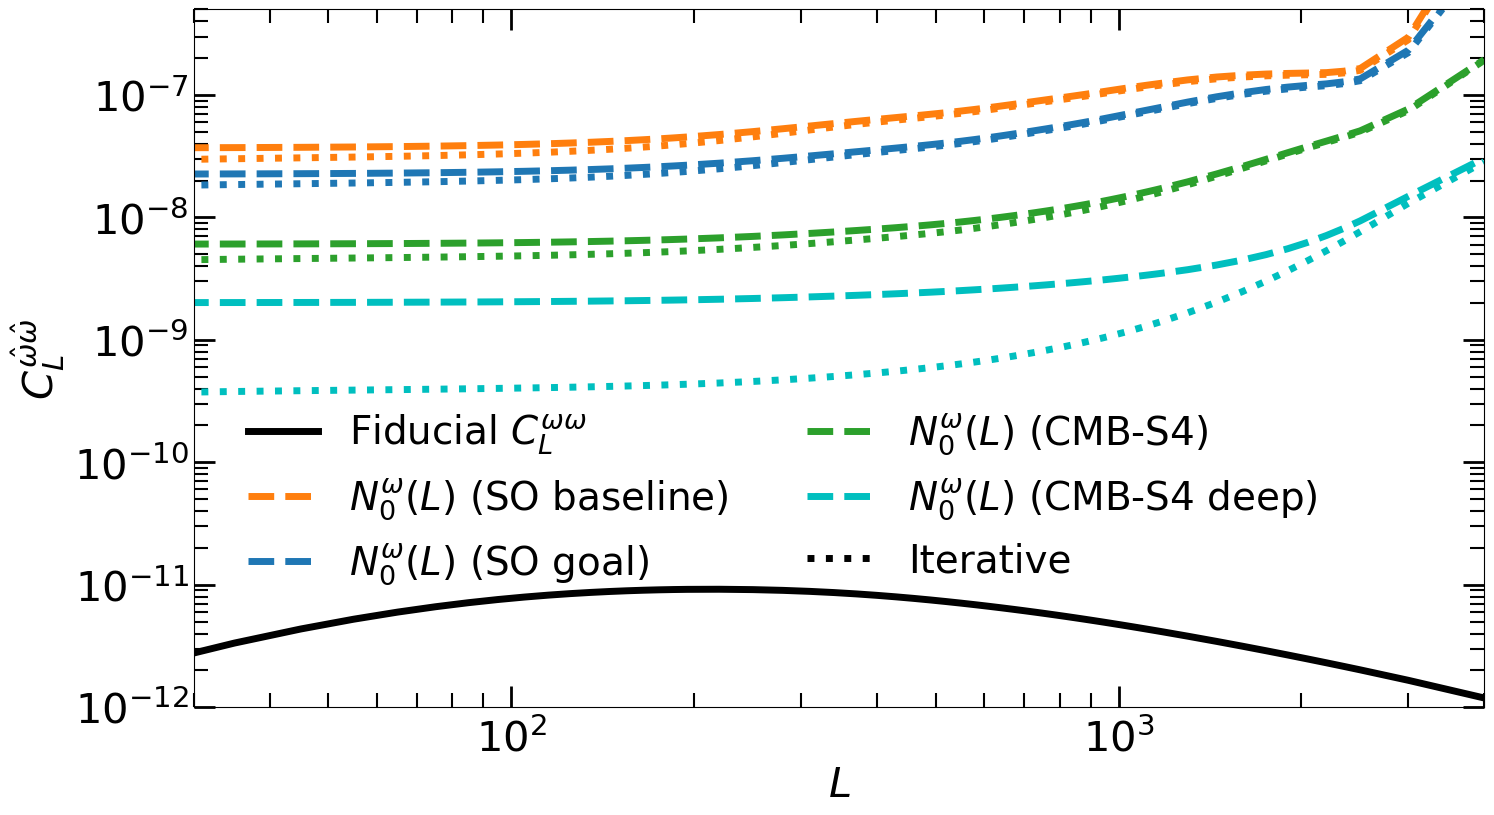

In [11]:
ellmax=4000
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.loglog(omega_Ls, my_omega_ps, label="Fiducial $C^{\omega\omega}_L$", linewidth=5, color="k")

reduced_exps = ["SO_base", "SO_goal", "S4_base", "S4_dp"]
for iii, exp in enumerate(reduced_exps):
    
    qe = "EB" if exp=="S4_dp" else "TEB"
    
    _noise.setup_cmb_noise(exp=exp, qe=qe)
    N_ww = _noise.get_N0("omega", ellmax=ellmax)
    ax.loglog(omega_Ls,N_ww[omega_Ls], linestyle="--", label="$N^{\omega}_0(L)$" +f" ({exps.get_label(exp)})", linewidth=5, color=exps.get_colour(exp))
    
    _noise.setup_cmb_noise(exp=exp, iter=True, qe=qe)
    N_ww = _noise.get_N0("omega", ellmax=ellmax)
    ax.loglog(omega_Ls,N_ww[omega_Ls], linestyle=":", linewidth=5, color=exps.get_colour(exp))
    


    
plt.plot([-1],[-1],color="k", linestyle=":", linewidth=5, label="Iterative")

ax.legend(prop={'size': 28}, frameon=False, ncol=2, loc=(0.03,0.15), handlelength=1.8)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}}$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_ylim(1e-12, 5e-7)
ax.set_xlim(30, 4e3)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)


# fig.savefig("_report_plots/omega_ps_all.pdf", bbox_inches='tight')
plt.show()


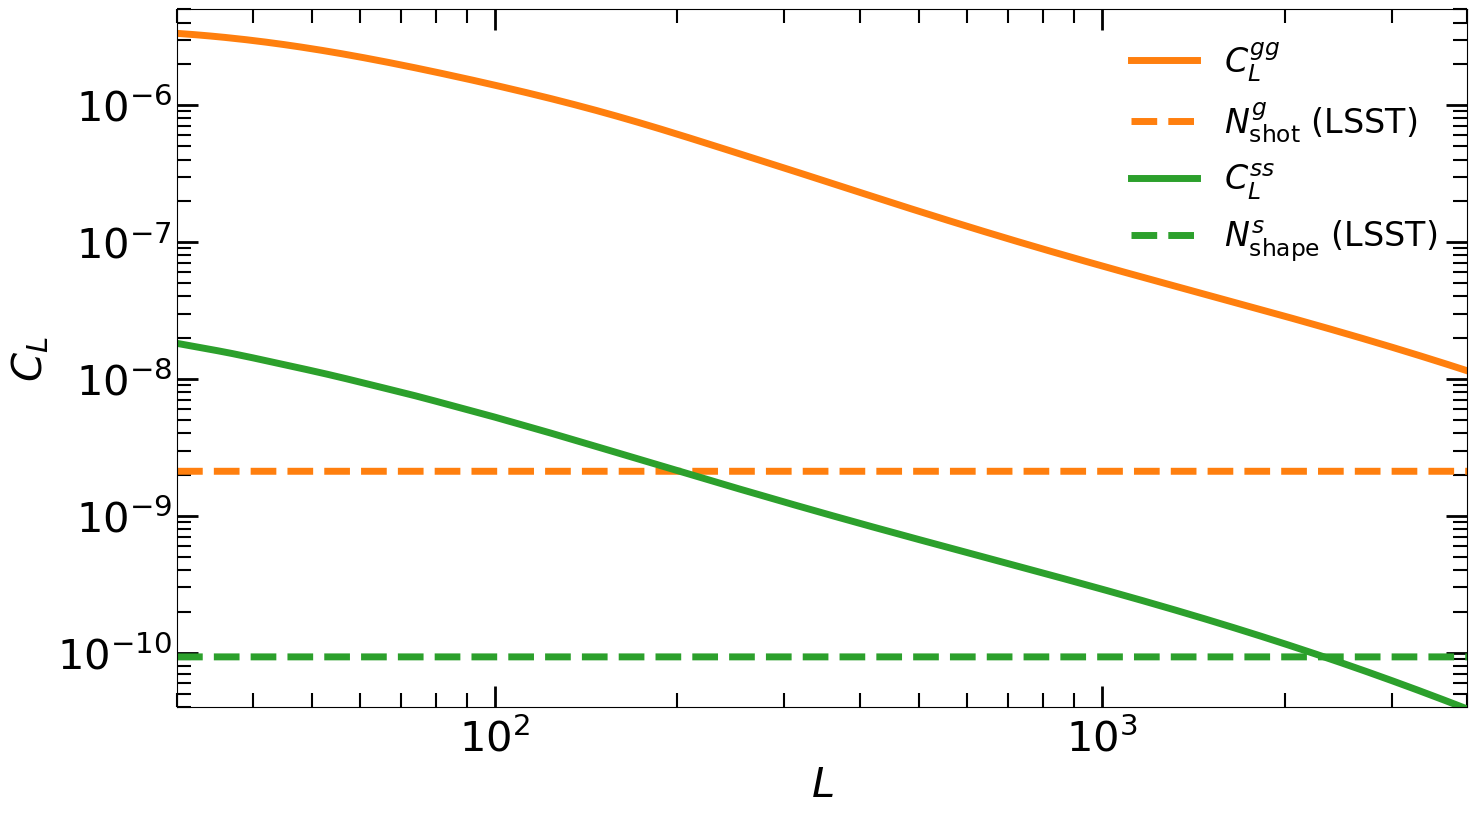

In [12]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax = 4000
ells = np.arange(30, ellmax + 1, 1)

Cl_ss = power.get_gal_lens_ps(ells)
N_ss = _noise.get_shape_N()
Cl_gg = power.get_gal_ps(ells)
N_gg = _noise.get_gal_shot_N(ellmax=ellmax)

ax.loglog(ells, Cl_gg, label="$C_{L}^{gg}$", linewidth=5, color=u'#ff7f0e')
ax.loglog(ells,N_gg[ells], label="$N^g_{\mathrm{shot}}$ (LSST)", linestyle="--", linewidth=5, color=u'#ff7f0e')
ax.loglog(ells, Cl_ss, label="$C_{L}^{ss}$", linewidth=5, color=u'#2ca02c')
ax.loglog(ells,N_ss[ells], label="$N^s_{\mathrm{shape}}$ (LSST)", linestyle="--", linewidth=5, color=u'#2ca02c')

ax.set_ylabel("$C_{L}$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,4000)
ax.set_ylim(4e-11, 5e-6)
ax.legend(prop={'size': 24}, frameon=False, loc=1)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)
# fig.savefig("_report_plots/gal_shear_ps.pdf", bbox_inches='tight')
plt.show()

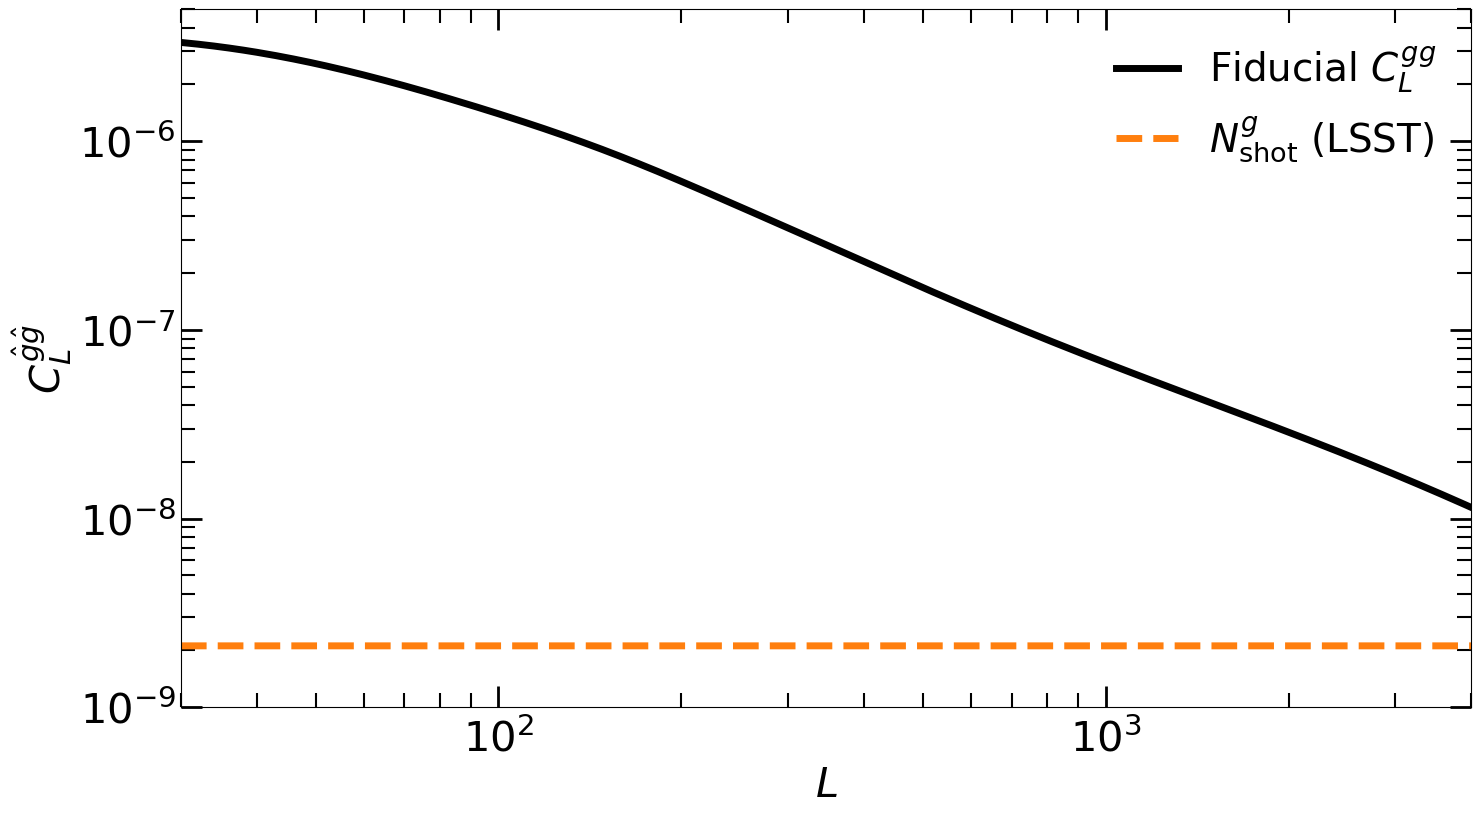

In [13]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax = 4000
ells = np.arange(30, ellmax + 1, 1)

Cl_ss = power.get_gal_lens_ps(ells)
N_ss = _noise.get_shape_N()
Cl_gg = power.get_gal_ps(ells)
N_gg = _noise.get_gal_shot_N(ellmax=ellmax)

ax.loglog(ells, Cl_gg, label="Fiducial $C_{L}^{gg}$", linewidth=5, color="k")
ax.loglog(ells,N_gg[ells], label="$N^g_{\mathrm{shot}}$ (LSST)", linestyle="--", linewidth=5, color=u'#ff7f0e')

ax.set_ylabel("$C^{\hat{g}\hat{g}}_{L}$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,4000)
ax.set_ylim(1e-9, 5e-6)
ax.legend(prop={'size': 28}, frameon=False, loc=1, handlelength=1.6)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)
# fig.savefig("_report_plots/gal_ps.pdf", bbox_inches='tight')
plt.show()

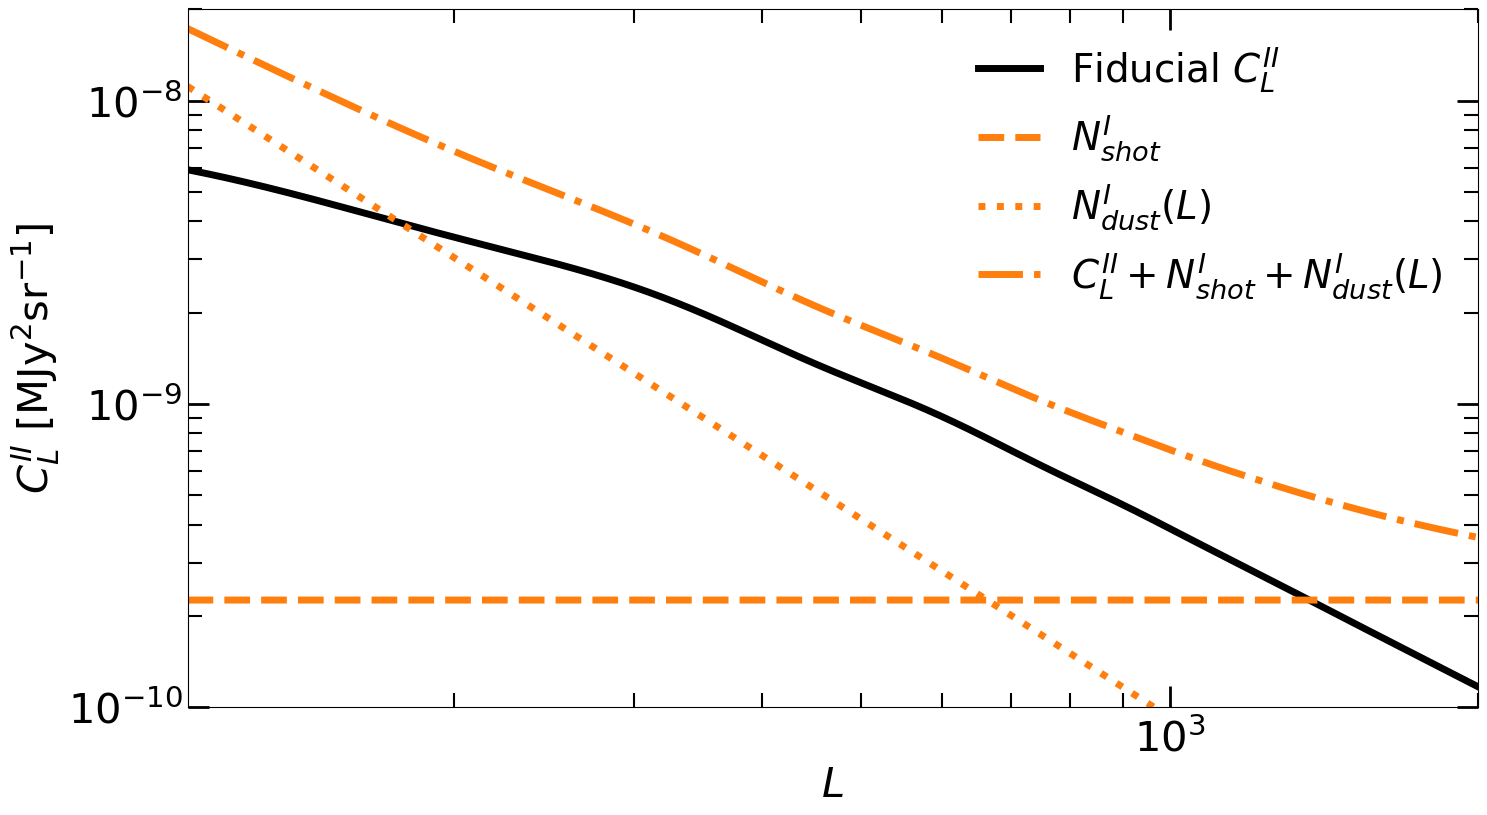

In [14]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ells = np.arange(110, 2000 + 1, 1)

Cl_II = power.get_cib_ps(ells, nu=353e9)
N_II = _noise.get_cib_shot_N(nu=353e9, ellmax=ellmax)
N_dust = _noise.get_dust_N(nu=353e9, ellmax=ellmax)

ax.loglog(ells, Cl_II, label="Fiducial $C^{II}_L$", linewidth=5, color="k")
ax.loglog(ells, N_II[ells], label="$N^{I}_{shot}$", linestyle="--", linewidth=5, color=u'#ff7f0e')
ax.loglog(ells, N_dust[ells], label="$N^{I}_{dust}(L)$", linestyle=":", linewidth=5, color=u'#ff7f0e')
ax.loglog(ells, (Cl_II + N_II[ells] + N_dust[ells]), label="$C^{II}_L + N^{I}_{shot} + N^{I}_{dust}(L)$",linestyle="dashdot", linewidth=5, color=u'#ff7f0e')

ax.set_ylabel("$C_{L}^{II}$ [MJy$^2$sr$^{-1}$]", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(110, 2000)
ax.set_ylim(1e-10,2e-8)
ax.legend(prop={'size': 28}, frameon=False, handlelength=1.6)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)
# fig.savefig("_report_plots/cib_ps.pdf", bbox_inches='tight')
plt.show()

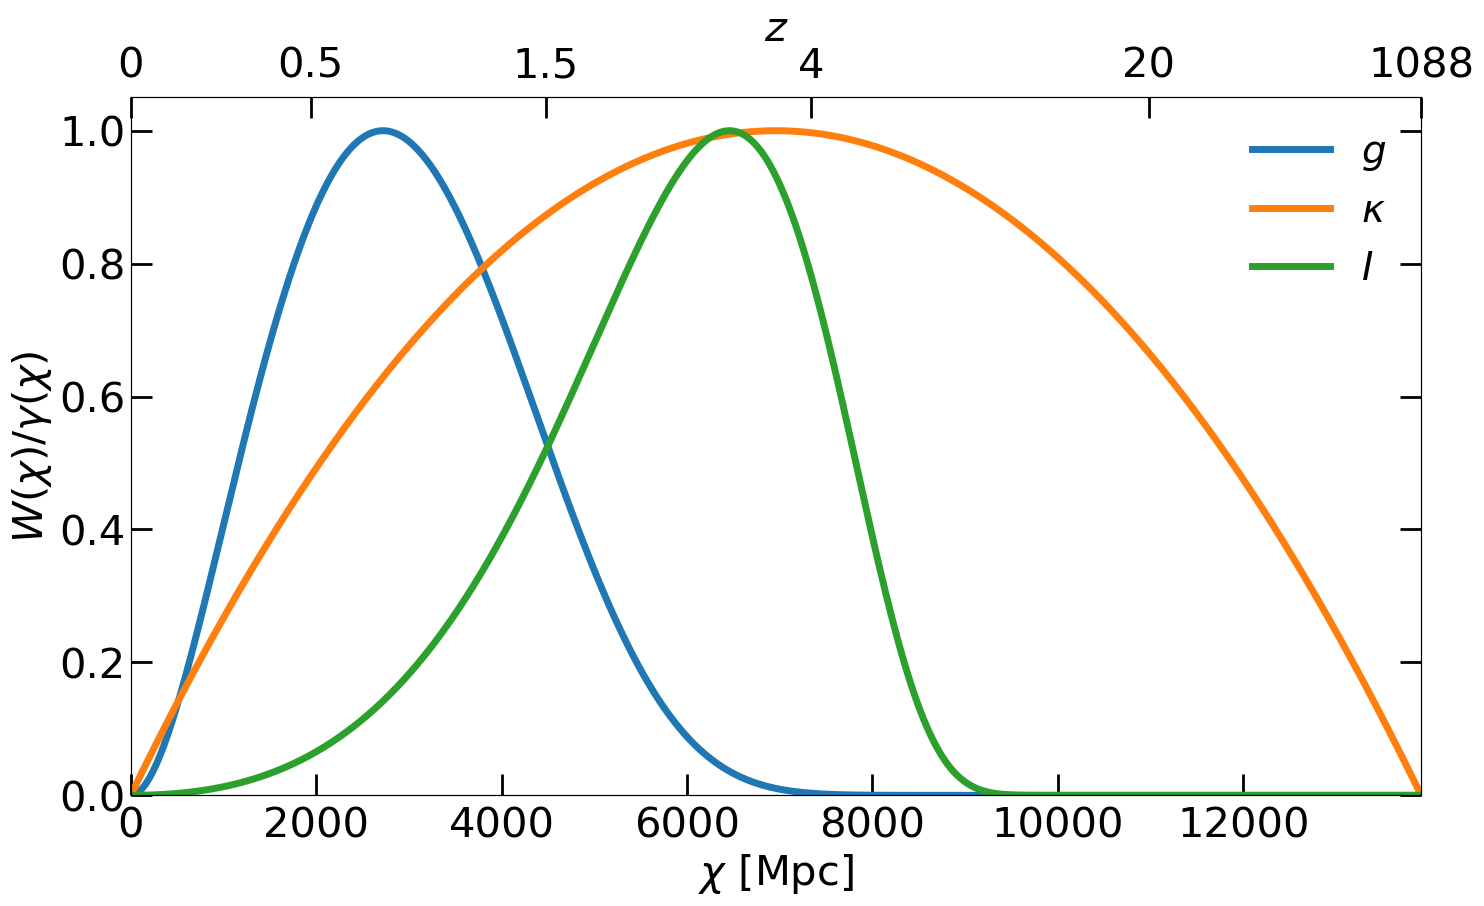

In [15]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

nu = 353e9
ellmax = 4000
ells = np.arange(2, ellmax + 1, 1)

Chi_str = cosmo.get_chi_star()
Chis = np.linspace(1, Chi_str, 1000)
zs = cosmo.Chi_to_z(Chis)

conv_fac = 1/cosmo.poisson_factor(zs)*Chis**2
gal_window_Chi = cosmo.gal_window_Chi(Chis)*conv_fac
cmb_window_Chi = cosmo.cmb_lens_window_matter(Chis, Chi_str)*conv_fac
cib_window_Chi = cosmo.cib_window_Chi(Chis, nu)*conv_fac
gal_lens_window_Chi = cosmo.gal_lens_window_matter(Chis, Chi_str)*conv_fac

ax.plot(Chis, gal_window_Chi/np.max(gal_window_Chi), label="$g$", linewidth=5)
ax.plot(Chis, cmb_window_Chi/np.max(cmb_window_Chi), label="$\kappa$", linewidth=5)
ax.plot(Chis, cib_window_Chi/np.max(cib_window_Chi), label="$I$", linewidth=5)
# ax.plot(Chis, gal_lens_window_Chi/np.max(gal_lens_window_Chi), label="$s$", linewidth=5)

ax.set_xlabel("$\chi$ [Mpc]", fontsize=30)
ax.set_ylabel(r"$W(\chi)/\gamma(\chi)$", fontsize=30)
ax.set_ylim(0,1.05)
plt.xlim(0,cosmo.get_chi_star())
ax.legend(prop={'size': 28}, frameon=False)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)


ax2 = ax.twiny()
ax2.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax2.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax2.tick_params(labelsize=30)
ax2.set_xlim(ax.get_xlim())
zs_ticks = np.array([0, 0.5, 1.5, 4, 20, cosmo.Chi_to_z(cosmo.get_chi_star())])
ax2.set_xticks(cosmo.z_to_Chi(zs_ticks))
ax2.set_xticklabels(["%.4g" % z for z in zs_ticks])
ax2.set_xlabel(r"$z$", fontsize=30)

# fig.savefig("_report_plots/windows.pdf", bbox_inches='tight')
plt.show()


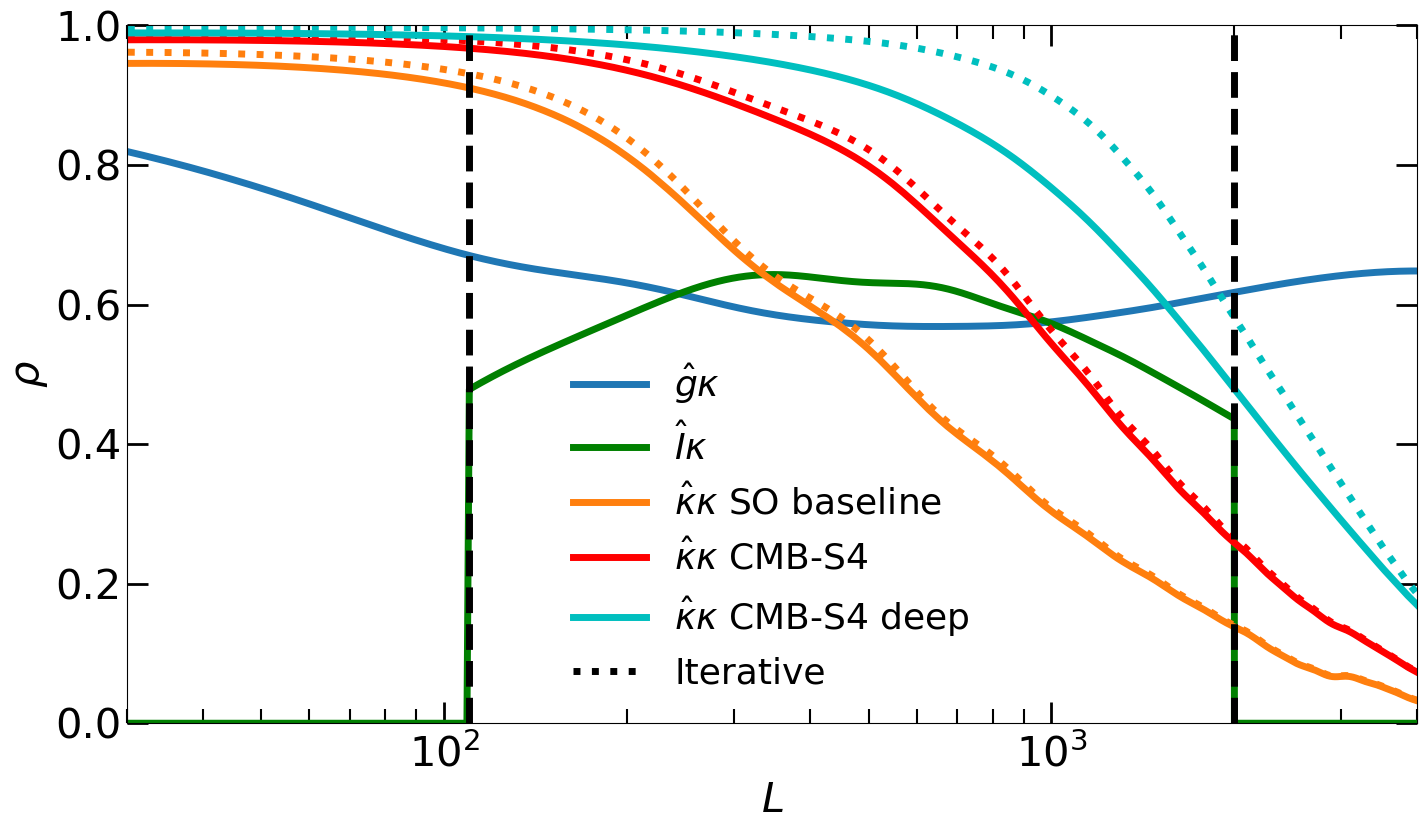

In [25]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax = 4000
ells2 = np.arange(ellmax + 1)

typs = ["gk", "Ik", "sk", "gI"]
colors = [u'#1f77b4', "g"]

labels = ["$\hat{g}\kappa$", "$\hat{I}\kappa$", "$\hat{s}\kappa$", "$\hat{g}\hat{I}$"]
for iii, typ in enumerate(typs[:2]):
    
    corr = fisher.covariance.get_corr(typ, ellmax, include_kappa_noise=False)
    plt.semilogx(ells2, corr, label=labels[iii], linewidth=5, color=colors[iii])

ells = np.arange(2,4001)
Cl_kk = power.get_kappa_ps(ells)

_exps = ["SO_base", "S4_base", "S4_dp"]
colours = [u'#ff7f0e', 'r', 'c']
for iii, exp in enumerate(_exps):
    qe = "EB" if exp=="S4_dp" else "TEB"
    
    _noise.setup_cmb_noise(exp=exp, ps="gradient", qe=qe)
    N_kk = _noise.get_N0("kappa", ellmax=ellmax)
    corr_kk = Cl_kk/(np.sqrt((Cl_kk + N_kk[ells])*Cl_kk))
    ax.semilogx(ells, corr_kk, label="$\hat{\kappa}\kappa$" + f" {exps.get_label(exp)}", linewidth=5, color=colours[iii])

    _noise.setup_cmb_noise(exp=exp, ps="gradient", iter=True, qe=qe)
    N_kk = _noise.get_N0("kappa", ellmax=ellmax)
    corr_kk = Cl_kk/(np.sqrt((Cl_kk + N_kk[ells])*Cl_kk))
    ax.semilogx(ells, corr_kk, linewidth=5, color=colours[iii], linestyle=":")


ax.semilogx([110,110],[0,1],linestyle="--",color="k",linewidth=5)
ax.semilogx([2000,2000],[0,1],linestyle="--",color="k",linewidth=5)

ax.plot([-1],[-1], ":", color="k", label="Iterative",linewidth=5)

ax.set_ylabel(r"$\rho$", fontsize=30)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,4000)
ax.set_ylim(0,1)
ax.legend(prop={'size': 26}, frameon=False, loc=8)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)
# fig.savefig("_report_plots/corr.pdf", bbox_inches='tight')
plt.show()

Time = 241.1608440876007


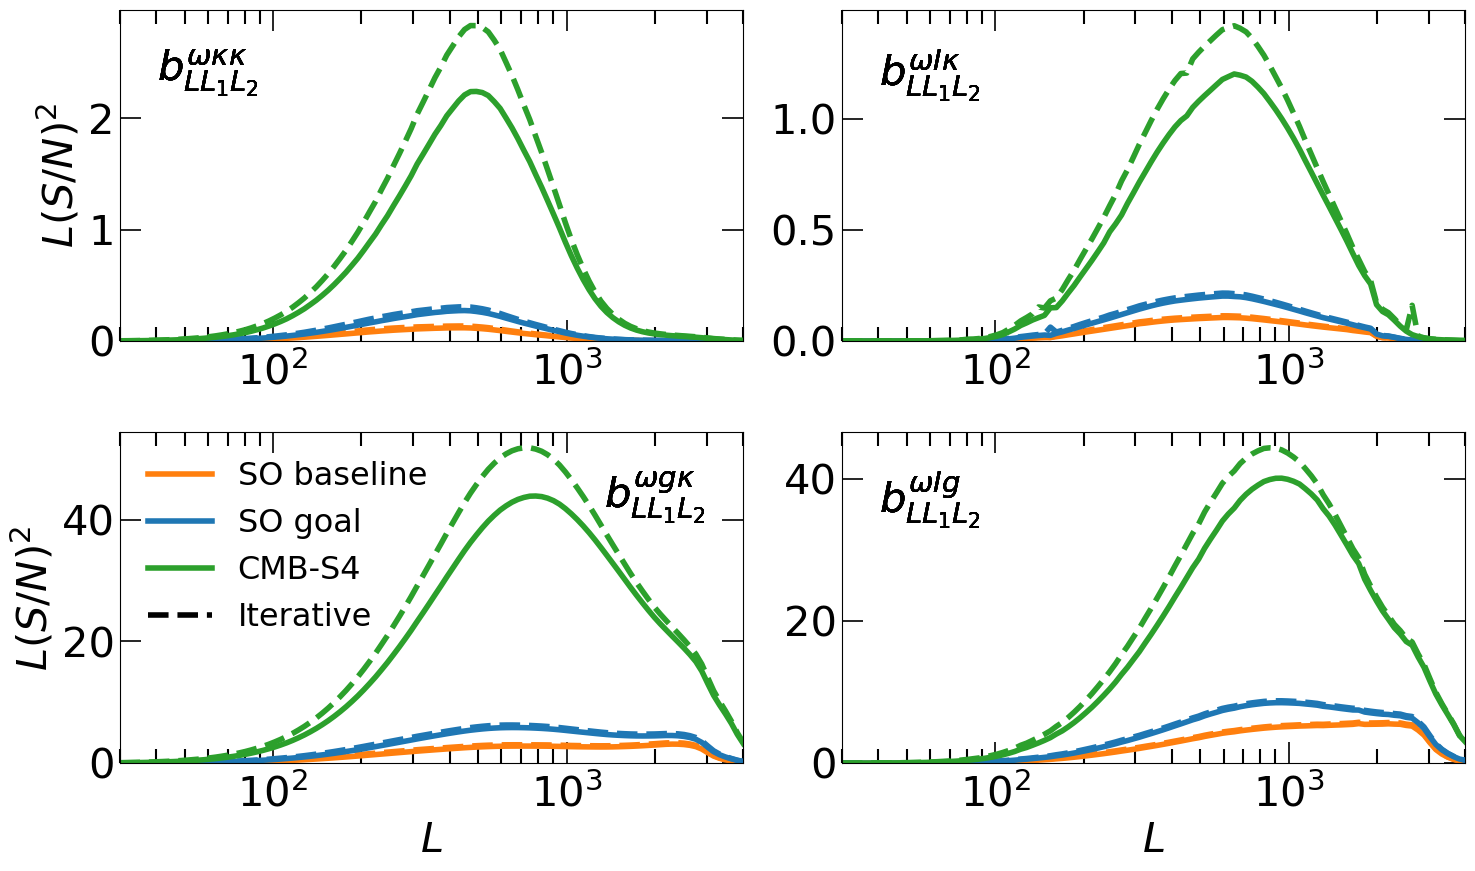

In [27]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=4)

Ls1 = np.arange(30,40,2)
Ls2 = np.logspace(1, 3, 100)*4
Ls = np.concatenate((Ls1,Ls2))
Ntheta=100
t0 = time.time()
label_typs = ["$b^{\omega\kappa\kappa}_{LL_1L_2}$", "$b^{\omega g\kappa}_{LL_1L_2}$", "$b^{\omega I\kappa}_{LL_1L_2}$", "$b^{\omega Ig}_{LL_1L_2}$"]
typs = ["kkw", "gkw", "Ikw", "Igw"]
_exps = ["SO_base", "SO_goal", "S4_base"]
its = [True, False]
for iii, exp in enumerate(_exps):
    for kkk, it in enumerate(its):
        fisher.setup_noise(exp=exp,ps="gradient", iter=it)
        linestyle="--" if it else "-"
        for jjj, typ in enumerate(typs):
            F_conv_rot = fisher.get_bispectrum_Fisher(typ, Ls=Ls, Ntheta=Ntheta, f_sky=0.4, arr=True)
            col = jjj//2
            if jjj % 2: row = 1
            else: row = 0
            if row == 1 and col == 0:
                anchored_text = AnchoredText(f"{label_typs[jjj]}", loc=1, frameon=False, prop={'size': 30})
            else:
                anchored_text = AnchoredText(f"{label_typs[jjj]}", loc=2, frameon=False, prop={'size': 30})
            ax[row][col].add_artist(anchored_text)
            if not it:
                ax[row][col].semilogx(Ls, Ls*F_conv_rot, label=f"{exps.get_label(exp)}", color=exps.get_colour(exp), linewidth=4, linestyle=linestyle)
            else:
                ax[row][col].semilogx(Ls, Ls*F_conv_rot, color=exps.get_colour(exp), linewidth=4, linestyle=linestyle)                
            ax[row][col].tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
            ax[row][col].tick_params(top=True, right=True, direction="in", which="major", length=15, width=1.2)
            ax[row][col].tick_params(labelsize=30)
            ax[row][col].set_xlim(30,4000)
            if iii==2:
                ax[row][col].set_ylim(bottom=0)
                
            if row == 1:
                ax[row][col].set_xlabel("$L$", fontsize=30)
            if col == 0:
                ax[row][col].set_ylabel("$L(S/N)^2$", fontsize=30)
                
ax[1][0].plot([-1],[-1], linestyle="--", label="Iterative", color="k", linewidth=4)
ax[1][0].legend(prop={'size': 23}, frameon=False)
            
t1 = time.time()
print(f"Time = {t1 - t0}")

# fig.savefig("_report_plots/bi_fish_reduced.pdf", bbox_inches='tight')
plt.show()

Time = 322.83054280281067


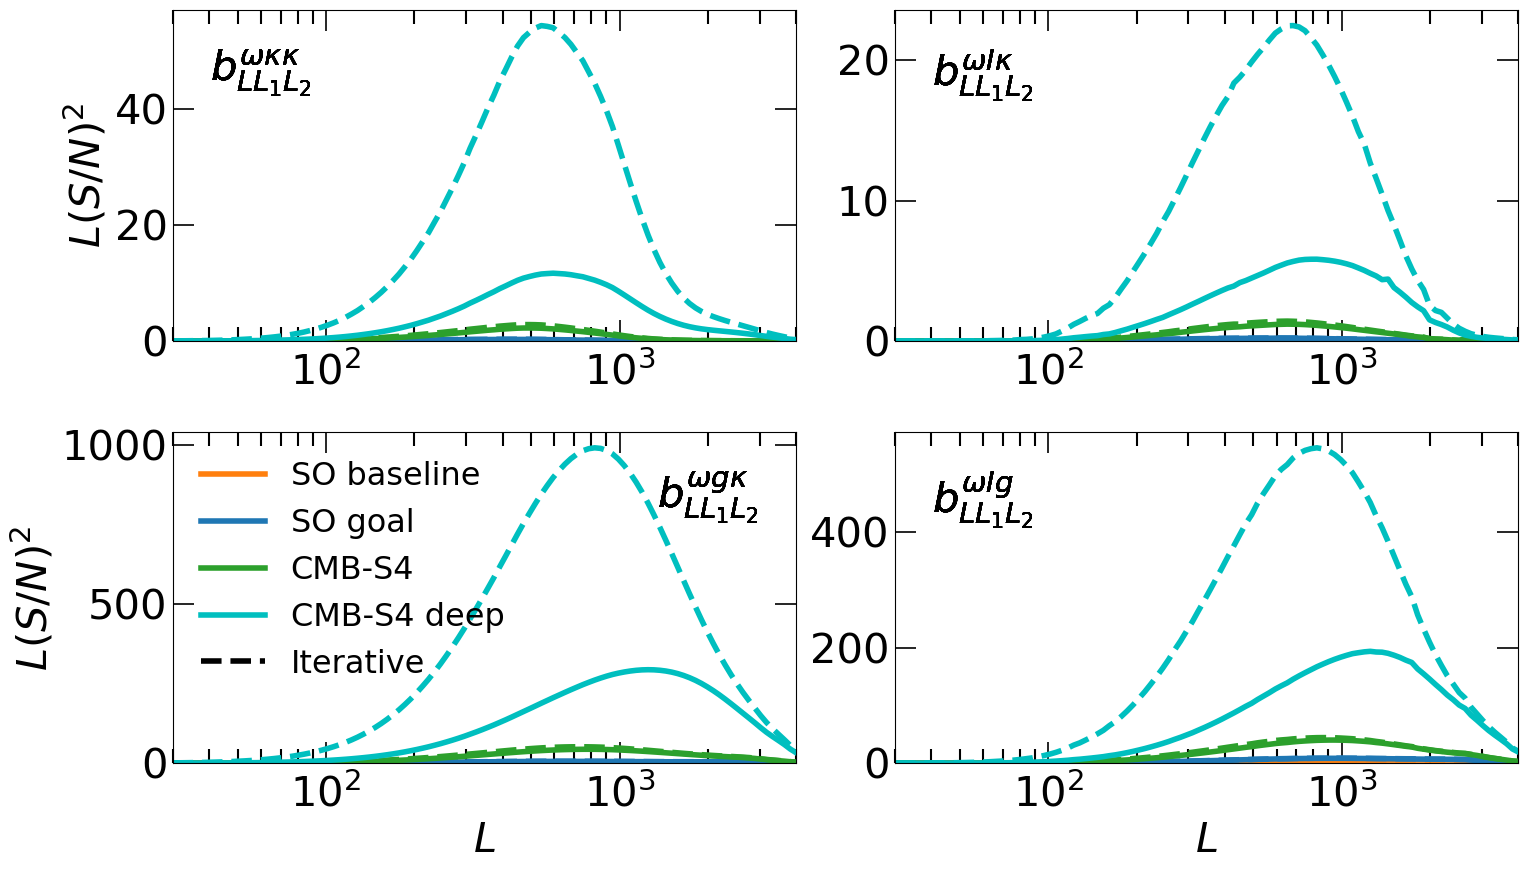

In [28]:
fig, ax = plt.subplots(2,2)
fig.tight_layout(pad=4)

Ls1 = np.arange(30,40,2)
Ls2 = np.logspace(1, 3, 100)*4
Ls = np.concatenate((Ls1,Ls2))
Ntheta=100
t0 = time.time()
label_typs = ["$b^{\omega\kappa\kappa}_{LL_1L_2}$", "$b^{\omega g\kappa}_{LL_1L_2}$", "$b^{\omega I\kappa}_{LL_1L_2}$", "$b^{\omega Ig}_{LL_1L_2}$"]
typs = ["kkw", "gkw", "Ikw", "Igw"]
its = [True, False]
for iii, exp in enumerate(exps.get_exps()):
    for kkk, it in enumerate(its):
        qe = "EB" if exp == "S4_deep" else "TEB"
        fisher.setup_noise(exp=exp,ps="gradient", iter=it, qe=qe)
        linestyle="--" if it else "-"
        for jjj, typ in enumerate(typs):
            f_sky = 0.05 if exp=="S4_deep" else 0.4
            F_conv_rot = fisher.get_bispectrum_Fisher(typ, Ls=Ls, Ntheta=Ntheta, f_sky=f_sky, arr=True)
            col = jjj//2
            if jjj % 2: row = 1
            else: row = 0
            if row == 1 and col == 0:
                anchored_text = AnchoredText(f"{label_typs[jjj]}", loc=1, frameon=False, prop={'size': 30})
            else:
                anchored_text = AnchoredText(f"{label_typs[jjj]}", loc=2, frameon=False, prop={'size': 30})
            ax[row][col].add_artist(anchored_text)
            if not it:
                ax[row][col].semilogx(Ls, Ls*F_conv_rot, label=f"{exps.get_label(exp)}", color=exps.get_colour(exp), linewidth=4, linestyle=linestyle)
            else:
                ax[row][col].semilogx(Ls, Ls*F_conv_rot, color=exps.get_colour(exp), linewidth=4, linestyle=linestyle)                
            ax[row][col].tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
            ax[row][col].tick_params(top=True, right=True, direction="in", which="major", length=15, width=1.2)
            ax[row][col].tick_params(labelsize=30)
            ax[row][col].set_xlim(30,4000)
            if iii==3:
                ax[row][col].set_ylim(bottom=0)
                
            if row == 1:
                ax[row][col].set_xlabel("$L$", fontsize=30)
            if col == 0:
                ax[row][col].set_ylabel("$L(S/N)^2$", fontsize=30)
                
ax[1][0].plot([-1],[-1], linestyle="--", label="Iterative", color="k", linewidth=4)
ax[1][0].legend(prop={'size': 23}, frameon=False)
            
t1 = time.time()
print(f"Time = {t1 - t0}")

# fig.savefig("_report_plots/bi_fish_reduced_w_S4_dp.pdf", bbox_inches='tight')
plt.show()

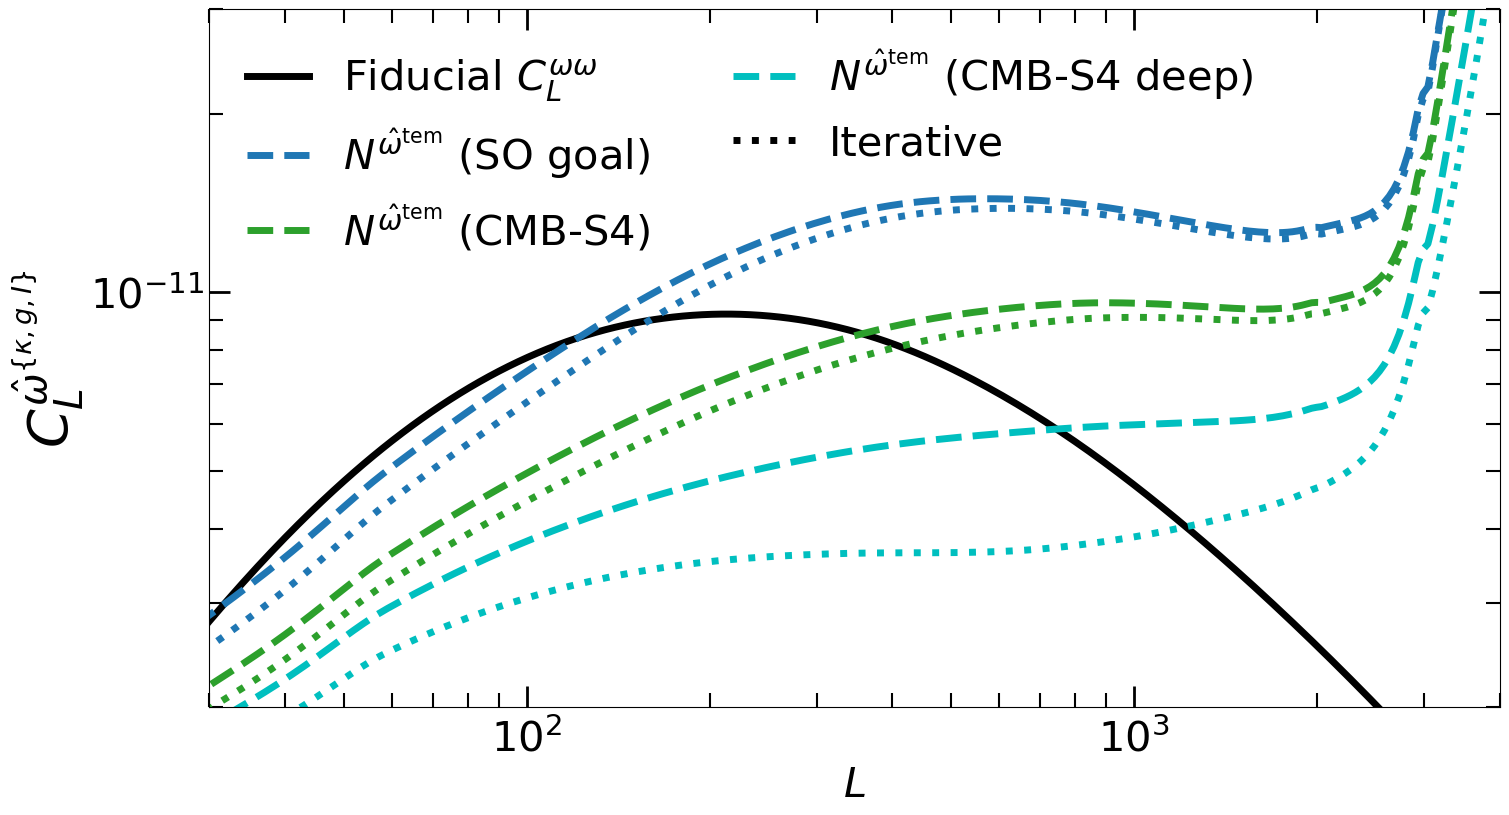

In [7]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

Ls = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv/TEB/30_3000/1_2000/Ls.npy")
F_L_kgI_SO_goal = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_SO_goal_it = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_base = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_base_it = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_dp = np.load(f"{results_dir}/F_L_results/kgI/S4_dp/gmv/EB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_dp_it = np.load(f"{results_dir}/F_L_results/kgI/S4_dp/gmv_iter/EB/30_3000/1_2000/F_L.npy")

my_omega_ps_spline = InterpolatedUnivariateSpline(omega_Ls, my_omega_ps)
ax.loglog(Ls, my_omega_ps_spline(Ls), label="Fiducial $C^{\omega\omega}_L$", linewidth=5, color="k")

ax.loglog(Ls, my_omega_ps_spline(Ls)/F_L_kgI_SO_goal - my_omega_ps_spline(Ls), linewidth=5, linestyle="--", color=exps.get_colour("SO_goal"))
ax.loglog(Ls, my_omega_ps_spline(Ls)/F_L_kgI_SO_goal_it - my_omega_ps_spline(Ls), linewidth=5, linestyle=":",color=exps.get_colour("SO_goal"))
ax.loglog(Ls, my_omega_ps_spline(Ls)/F_L_kgI_S4_base - my_omega_ps_spline(Ls), linewidth=5, linestyle="--",color=exps.get_colour("S4_base"))
ax.loglog(Ls, my_omega_ps_spline(Ls)/F_L_kgI_S4_base_it - my_omega_ps_spline(Ls), linewidth=5, linestyle=":",color=exps.get_colour("S4_base"))
ax.loglog(Ls, my_omega_ps_spline(Ls)/F_L_kgI_S4_dp - my_omega_ps_spline(Ls), linewidth=5, linestyle="--",color=exps.get_colour("S4_dp"))
ax.loglog(Ls, my_omega_ps_spline(Ls)/F_L_kgI_S4_dp_it - my_omega_ps_spline(Ls), linewidth=5, linestyle=":",color=exps.get_colour("S4_dp"))



ax.plot([-1],[-1], label="$N^{\hat{\omega}^{\mathrm{tem}}}$ (SO goal)", color=exps.get_colour("SO_goal"), linewidth=5, linestyle="--")
ax.plot([-1],[-1], label="$N^{\hat{\omega}^{\mathrm{tem}}}$ (CMB-S4)", color=exps.get_colour("S4_base"), linewidth=5, linestyle="--")
ax.plot([-1],[-1], label="$N^{\hat{\omega}^{\mathrm{tem}}}$ (CMB-S4 deep)", color=exps.get_colour("S4_dp"), linewidth=5, linestyle="--")
ax.plot([-1],[-1], label="Iterative", color="k", linewidth=5, linestyle=":")


ax.set_ylabel("$C^{\hat{\omega}^{\{\kappa,g,I\}}}_L$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,4000)
ax.set_ylim(2e-12,3e-11)
ax.legend(prop={'size': 30}, frameon=False, handlelength=1.5, loc=2, ncol=2)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

t1 = time.time()
# fig.savefig("_report_plots/omega_lss_ps_single_all.pdf", bbox_inches='tight')
plt.show()


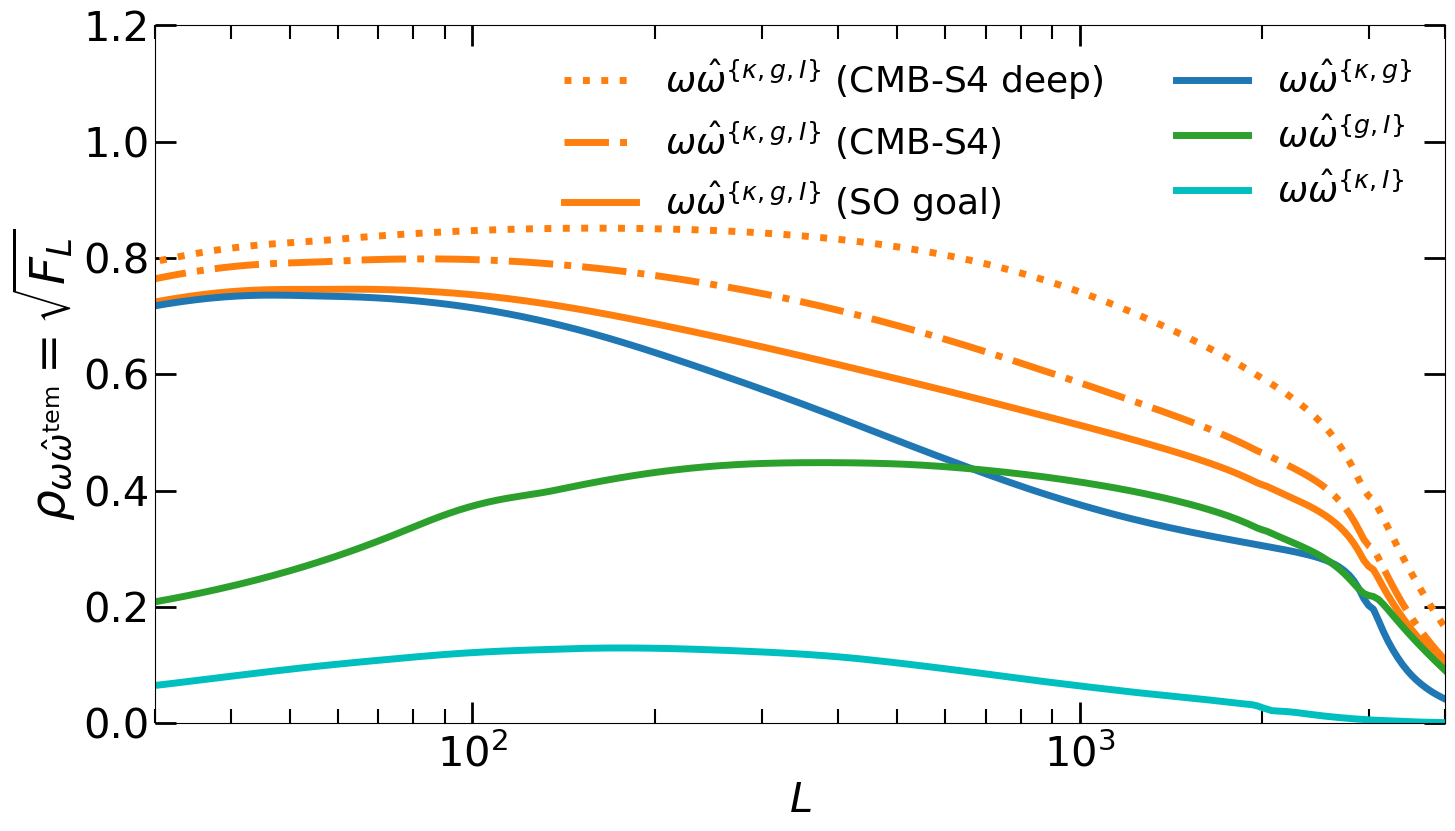

In [8]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)


Ls = np.load(f"{results_dir}/F_L_results/kgI/S4_dp/gmv_iter/EB/30_3000/1_2000/Ls.npy")
F_L = np.load(f"{results_dir}/F_L_results/kgI/S4_dp/gmv_iter/EB/30_3000/1_2000/F_L.npy")
ax.semilogx(Ls, np.sqrt(F_L), label="$\omega\hat{\omega}^{\{\kappa,g,I\}}$ (CMB-S4 deep)", linewidth=5, color=u'#ff7f0e', linestyle=":")

Ls = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv_iter/TEB/30_3000/1_2000/Ls.npy")
F_L = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
ax.semilogx(Ls, np.sqrt(F_L), label="$\omega\hat{\omega}^{\{\kappa,g,I\}}$ (CMB-S4)", linewidth=5, color=u'#ff7f0e', linestyle="-.")


typs = ["kgI", "kg", "gI", "kI"]
colors = [u'#ff7f0e', u'#1f77b4', u'#2ca02c', "c"]
label_typs = ["$\omega\hat{\omega}^{\{\kappa,g,I\}}$ (SO goal)", "$\omega\hat{\omega}^{\{\kappa,g\}}$", "$\omega\hat{\omega}^{\{g,I\}}$", "$\omega\hat{\omega}^{\{\kappa,I\}}$"]
for iii, typ in enumerate(typs):
    #if iii == 1:
        #ax.plot([-1],[-1], color="white", alpha=0, label=" ")
    Ls = np.load(f"{results_dir}/F_L_results/{typ}/SO_goal/gmv_iter/TEB/30_3000/1_2000/Ls.npy")
    F_L = np.load(f"{results_dir}/F_L_results/{typ}/SO_goal/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
    ax.semilogx(Ls, np.sqrt(F_L), label=label_typs[iii], linewidth=5, color=colors[iii])

ax.set_ylabel(r'$\rho_{\omega\hat{\omega}^{\mathrm{tem}}}=\sqrt{F_L}$', fontsize=35)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,4000)
ax.set_ylim(0,1.2)
ax.legend(prop={'size': 26}, frameon=False, ncol=2)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)
# fig.savefig("_report_plots/omega_corr_SO.pdf", bbox_inches='tight')
plt.show()

L bins: [  30.           40.           55.57981977   77.22790916  107.30783181
  149.10374881  207.17898717  287.8742692   400.          555.79819775
  772.27909155 1073.07831811 1491.03748813 2071.78987169 2878.742692
 4000.        ]
SO_base
SO_goal
S4_base
S4_dp


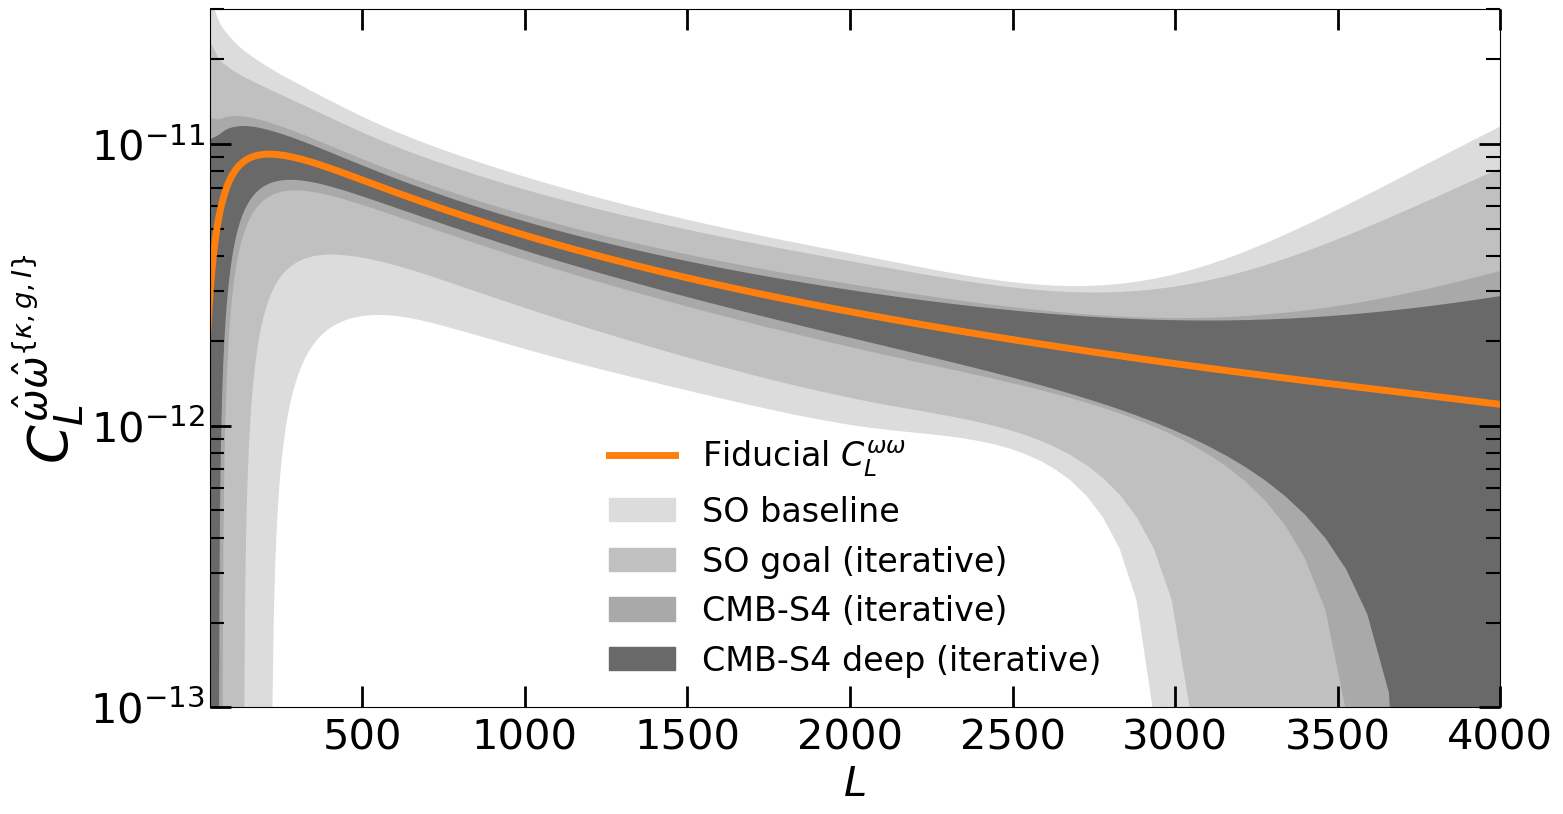

In [9]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax=4000

Ls = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv/TEB/30_3000/1_2000/Ls.npy")
F_L_kgI_SO_base = np.load(f"{results_dir}/F_L_results/kgI/SO_base/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_SO_goal = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_SO_goal_it = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_base = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_base_it = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_dp = np.load(f"{results_dir}/F_L_results/kgI/S4_dp/gmv/EB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_dp_it = np.load(f"{results_dir}/F_L_results/kgI/S4_dp/gmv_iter/EB/30_3000/1_2000/F_L.npy")


F_L_kgI_SO_base_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_SO_base)
F_L_kgI_SO_goal_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_SO_goal_it)
F_L_kgI_S4_base_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_S4_base_it)
F_L_kgI_S4_dp_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_S4_dp_it)


omega_ps_spline = InterpolatedUnivariateSpline(omega_Ls, my_omega_ps)

Ls1 = np.arange(30,40,10)
Ls2 = np.logspace(1, 3, 15)*4
Ls_sig = np.concatenate((Ls1,Ls2))
print(f"L bins: {Ls_sig}")

Ls_sig_big = np.concatenate((Ls1,Ls2))
Ls_sig_big = np.append(Ls_sig_big, Ls_sig[-1]+(Ls_sig[-1]-Ls_sig[-2]))
Ls_sig_big = np.append([Ls_sig[0]-(Ls_sig[1]-Ls_sig[0])], Ls_sig_big)
ns = [(Ls_sig_big[iii]-Ls_sig_big[iii])/2 + (Ls_sig_big[iii+1]-Ls_sig_big[iii-1])/2 for iii in range(1, np.size(Ls_sig)+1)]

fsky = 0.4
labels = ["SO baseline", "SO goal (iterative)", "CMB-S4 (iterative)", "CMB-S4 deep (iterative)"]
colours = ["gainsboro", "silver", "darkgray", "dimgray"]

ax.plot(Ls, omega_ps_spline(Ls), label="Fiducial $C^{\omega\omega}_L$", linewidth=5, color=u'#ff7f0e')
F_Ls = [F_L_kgI_SO_base_spline(Ls_sig), F_L_kgI_SO_goal_spline(Ls_sig), F_L_kgI_S4_base_spline(Ls_sig), F_L_kgI_S4_dp_spline(Ls_sig)]

iters = [False, True, True, True]

for iii, exp in enumerate(exps.get_exps()):
    print(exp)
    qe = "EB" if exp == "S4_dp" else "TEB"
    fsky = 0.05 if exp == "S4_dp" else 0.4
    N_ww = _noise.get_N0("omega", exp=exp, ellmax=ellmax, qe=qe, iter=iters[iii], recalc_N0=True)
    N_ww_spline = InterpolatedUnivariateSpline(np.arange(ellmax+1)[2:], N_ww[2:])
    sig2 = omega_ps_spline(Ls_sig)*N_ww_spline(Ls_sig)/F_Ls[iii]/(2*Ls_sig)
    sig = np.sqrt(sig2/fsky)
    err = sig/(np.sqrt(ns))
    err_spline = InterpolatedUnivariateSpline(Ls_sig,err)
    ax.plot(Ls, omega_ps_spline(Ls)+err_spline(Ls), linewidth=5, linestyle="--", alpha=0)
    ax.semilogy(Ls, omega_ps_spline(Ls)-err_spline(Ls), linewidth=5, linestyle="--", alpha=0)
    ax.fill_between(Ls, omega_ps_spline(Ls)+err_spline(Ls),omega_ps_spline(Ls)-err_spline(Ls), color=colours[iii], alpha=1, label=labels[iii])



ax.set_ylabel("$C^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}_{L}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,4000)
ax.set_ylim(1e-13,3e-11)
ax.legend(prop={'size': 24}, frameon=False, loc=8)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)


# fig.savefig("_report_plots/omega_cross_binned_semilogy_fsky.pdf", bbox_inches='tight')
plt.show()

L bins: [  30.           40.           55.57981977   77.22790916  107.30783181
  149.10374881  207.17898717  287.8742692   400.          555.79819775
  772.27909155 1073.07831811 1491.03748813 2071.78987169 2878.742692
 4000.        ]


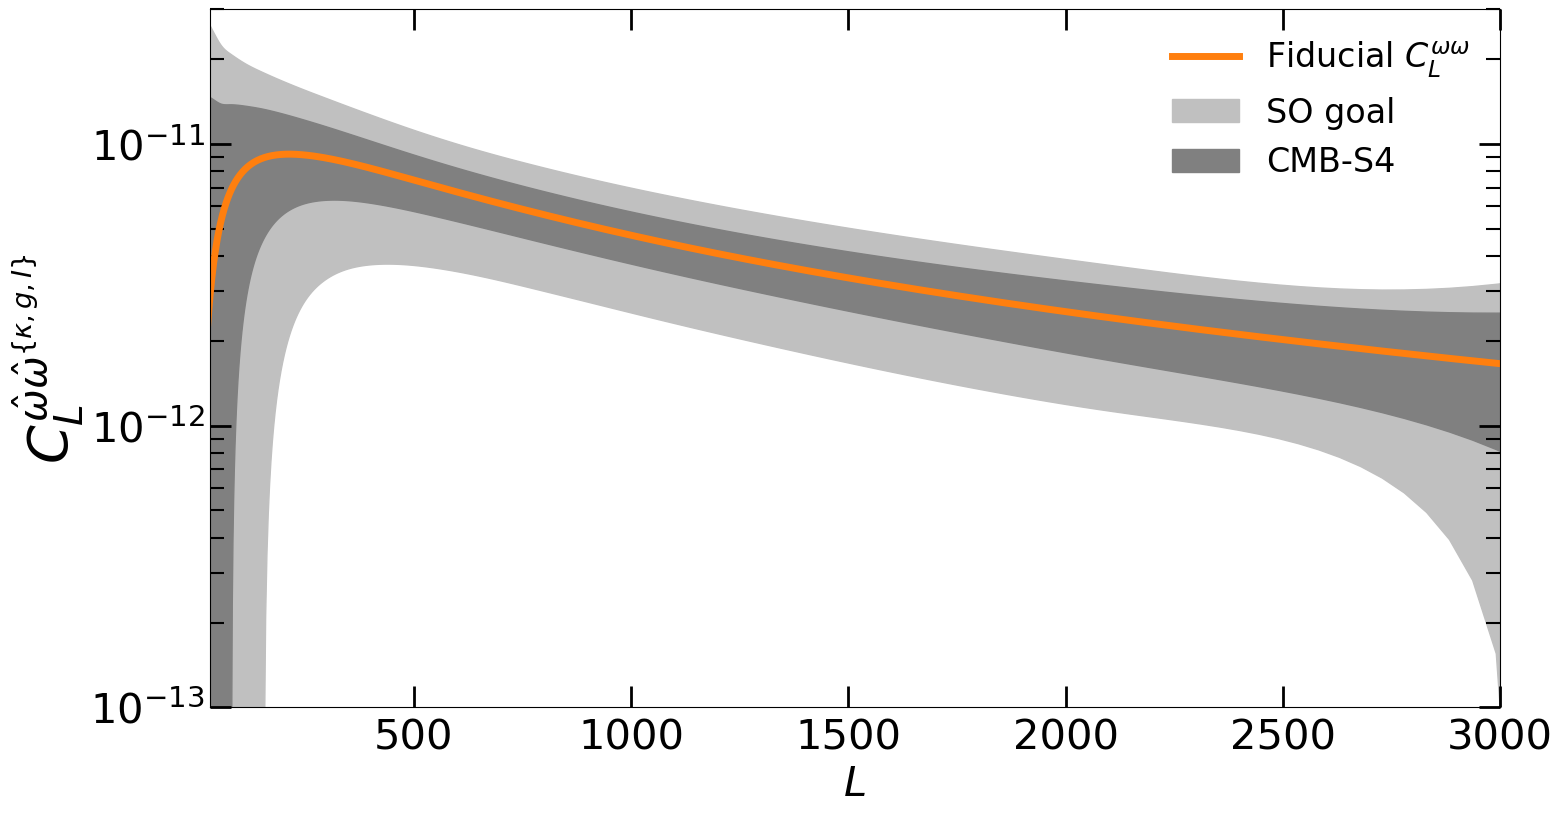

In [10]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ellmax=4000

Ls = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv/TEB/30_3000/1_2000/Ls.npy")
F_L_kgI_SO_base = np.load(f"{results_dir}/F_L_results/kgI/SO_base/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_SO_goal = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_SO_goal_it = np.load(f"{results_dir}/F_L_results/kgI/SO_goal/gmv_iter/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_base = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv/TEB/30_3000/1_2000/F_L.npy")
F_L_kgI_S4_base_it = np.load(f"{results_dir}/F_L_results/kgI/S4_base/gmv_iter/TEB/30_3000/1_2000/F_L.npy")

F_L_kgI_SO_base_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_SO_base)
F_L_kgI_SO_goal_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_SO_goal)
F_L_kgI_S4_base_spline = InterpolatedUnivariateSpline(Ls, F_L_kgI_S4_base)

omega_ps_spline = InterpolatedUnivariateSpline(omega_Ls, my_omega_ps)

Ls1 = np.arange(30,40,10)
Ls2 = np.logspace(1, 3, 15)*4
Ls_sig = np.concatenate((Ls1,Ls2))
print(f"L bins: {Ls_sig}")

Ls_sig_big = np.concatenate((Ls1,Ls2))
Ls_sig_big = np.append(Ls_sig_big, Ls_sig[-1]+(Ls_sig[-1]-Ls_sig[-2]))
Ls_sig_big = np.append([Ls_sig[0]-(Ls_sig[1]-Ls_sig[0])], Ls_sig_big)
ns = [(Ls_sig_big[iii]-Ls_sig_big[iii])/2 + (Ls_sig_big[iii+1]-Ls_sig_big[iii-1])/2 for iii in range(1, np.size(Ls_sig)+1)]

fsky = 0.4
labels = ["SO goal", "CMB-S4"]
colours = ["silver", "grey"]

ax.plot(Ls, omega_ps_spline(Ls), label="Fiducial $C^{\omega\omega}_L$", linewidth=5, color=u'#ff7f0e')
F_Ls = [F_L_kgI_SO_base_spline(Ls_sig), F_L_kgI_SO_goal_spline(Ls_sig), F_L_kgI_S4_base_spline(Ls_sig)]


configs = ["SO_goal", "S4_base"]
for iii, exp in enumerate(configs):

    N_ww = _noise.get_N0("omega", exp=exp, ellmax=ellmax, recalc_N0=True)
    N_ww_spline = InterpolatedUnivariateSpline(np.arange(ellmax+1)[2:], N_ww[2:])
    sig2 = ((omega_ps_spline(Ls_sig)+N_ww_spline(Ls_sig))*omega_ps_spline(Ls_sig)/F_Ls[iii] + omega_ps_spline(Ls_sig)**2)/(2*Ls_sig + 1)
    sig = np.sqrt(sig2/fsky)
    err = sig/(np.sqrt(ns))
    err_spline = InterpolatedUnivariateSpline(Ls_sig,err)
    ax.plot(Ls, omega_ps_spline(Ls)+err_spline(Ls), linewidth=5, linestyle="--", alpha=0)
    ax.semilogy(Ls, omega_ps_spline(Ls)-err_spline(Ls), linewidth=5, linestyle="--", alpha=0)
    ax.fill_between(Ls, omega_ps_spline(Ls)+err_spline(Ls),omega_ps_spline(Ls)-err_spline(Ls), color=colours[iii], alpha=1, label=labels[iii])



ax.set_ylabel("$C^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}_{L}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.set_xlim(30,3000)
ax.set_ylim(1e-13,3e-11)
ax.legend(prop={'size': 24}, frameon=False)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)


# fig.savefig("_report_plots/omega_cross_binned_semilogy_fsky.pdf", bbox_inches='tight')
plt.show()

In [11]:
def get_ps_binned(ks, ps, nBins=20):
    means, bin_edges, binnumber = stats.binned_statistic(ks, ps, 'mean', bins=nBins)
    binSeperation = bin_edges[1] - bin_edges[0]
    kBins = np.asarray([bin_edges[i] - binSeperation / 2 for i in range(1, len(bin_edges))])
    counts, *others = stats.binned_statistic(ks, ps, 'count', bins=nBins)
    stds, *others = stats.binned_statistic(ks, ps, 'std', bins=nBins)
    errors = stds / np.sqrt(counts)
    return means, kBins, errors

In [12]:
def get_ps(path, Nbins):
    ks = np.load(path+"/Ls.npy")
    all_ps = np.load(path+"/ps.npy")
    Nsims = np.shape(all_ps)[0]
    ps_binned, kBins, errs = get_ps_binned(ks, all_ps[0], Nbins)
    std, *others = stats.binned_statistic(ks, all_ps[0], 'std', bins=Nbins)
    ps_binned_all = np.zeros((Nsims, np.size(ps_binned)))
    err_all = np.zeros((Nsims, np.size(ps_binned)))
    var_all = np.zeros((Nsims, np.size(ps_binned)))
    ps_binned_all[0] = ps_binned
    err_all[0] = errs
    var_all[0] = std**2
    for sim in np.arange(1, Nsims):
        ps_binned_tmp, kBins, errs = get_ps_binned(ks, all_ps[sim], Nbins)
        std, *others = stats.binned_statistic(ks, all_ps[sim], 'std', bins=Nbins)
        ps_binned_all[sim] = ps_binned_tmp
        err_all[sim] = errs
        var_all[sim] = std**2

    ps = np.mean(ps_binned_all, axis=0)
    err = np.std(ps_binned_all, axis=0)/(np.sqrt(Nsims))
    return ps, kBins, err


In [14]:
Ls_S4 = np.load(f"{results_dir}/bias_results/S4_base/TEB_gmv/kgI/Ls.npy")
N_S4 = np.load(f"{results_dir}/bias_results/S4_base/TEB_gmv/kgI/N.npy")
Ls_SOg = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/kgI/Ls.npy")
N_SOg = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/kgI/N.npy")
Ls_SOg_gI = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/gI/Ls.npy")
N_SOg_gI = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/gI/N.npy")
Ls_SOg_kI = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/kI/Ls.npy")
N_SOg_kI = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/kI/N.npy")
Ls_SOg_kg = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/kg/Ls.npy")
N_SOg_kg = np.load(f"{results_dir}/bias_results/SO_goal/TEB_gmv/kg/N.npy")

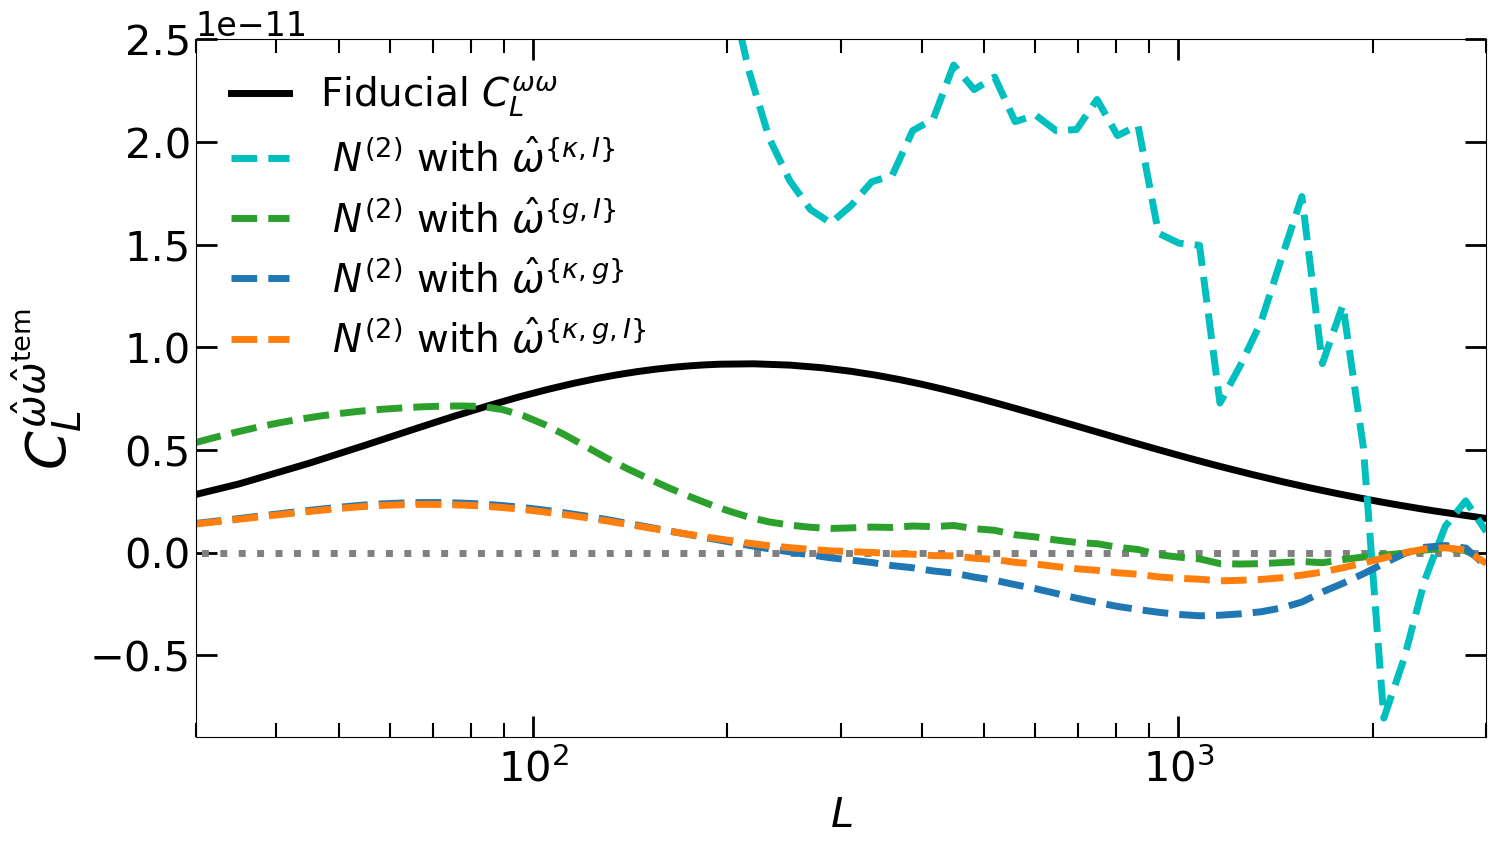

In [15]:
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax.semilogx(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
# ax.plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4 $\{\kappa,g,I\}$", linewidth=5, linestyle="--")
ax.plot(Ls_SOg_kI, N_SOg_kI, color="c", label=" $N^{(2)}$ with $\hat{\omega}^{\{\kappa,I\}}$", linewidth=5, linestyle="--")
ax.plot(Ls_SOg_gI, N_SOg_gI, color=u'#2ca02c', label=" $N^{(2)}$ with $\hat{\omega}^{\{g,I\}}$", linewidth=5, linestyle="--")
ax.plot(Ls_SOg_kg, N_SOg_kg, color=u'#1f77b4', label=" $N^{(2)}$ with $\hat{\omega}^{\{\kappa,g\}}$", linewidth=5, linestyle="--")
ax.plot(Ls_SOg, N_SOg, color=u'#ff7f0e', label=" $N^{(2)}$ with $\hat{\omega}^{\{\kappa,g,I\}}$", linewidth=5, linestyle="--")


ax.set_xlim(3e1,3e3)
ax.set_ylim(-9e-12,2.5e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 28}, frameon=False, handlelength=1.5)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^\mathrm{tem}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results_all.pdf", bbox_inches='tight')
plt.show()

In [16]:
ps_SO, ks_SO, err_SO = get_ps(f"{results_dir}/simbias_results/kgI/SO_goal/gmv/TEB/12_14/30_3000/100/",30)
ps_S4, ks_S4, err_S4 = get_ps(f"{results_dir}/simbias_results/kgI/S4_base/gmv/TEB/12_14/30_3000/100/",30)


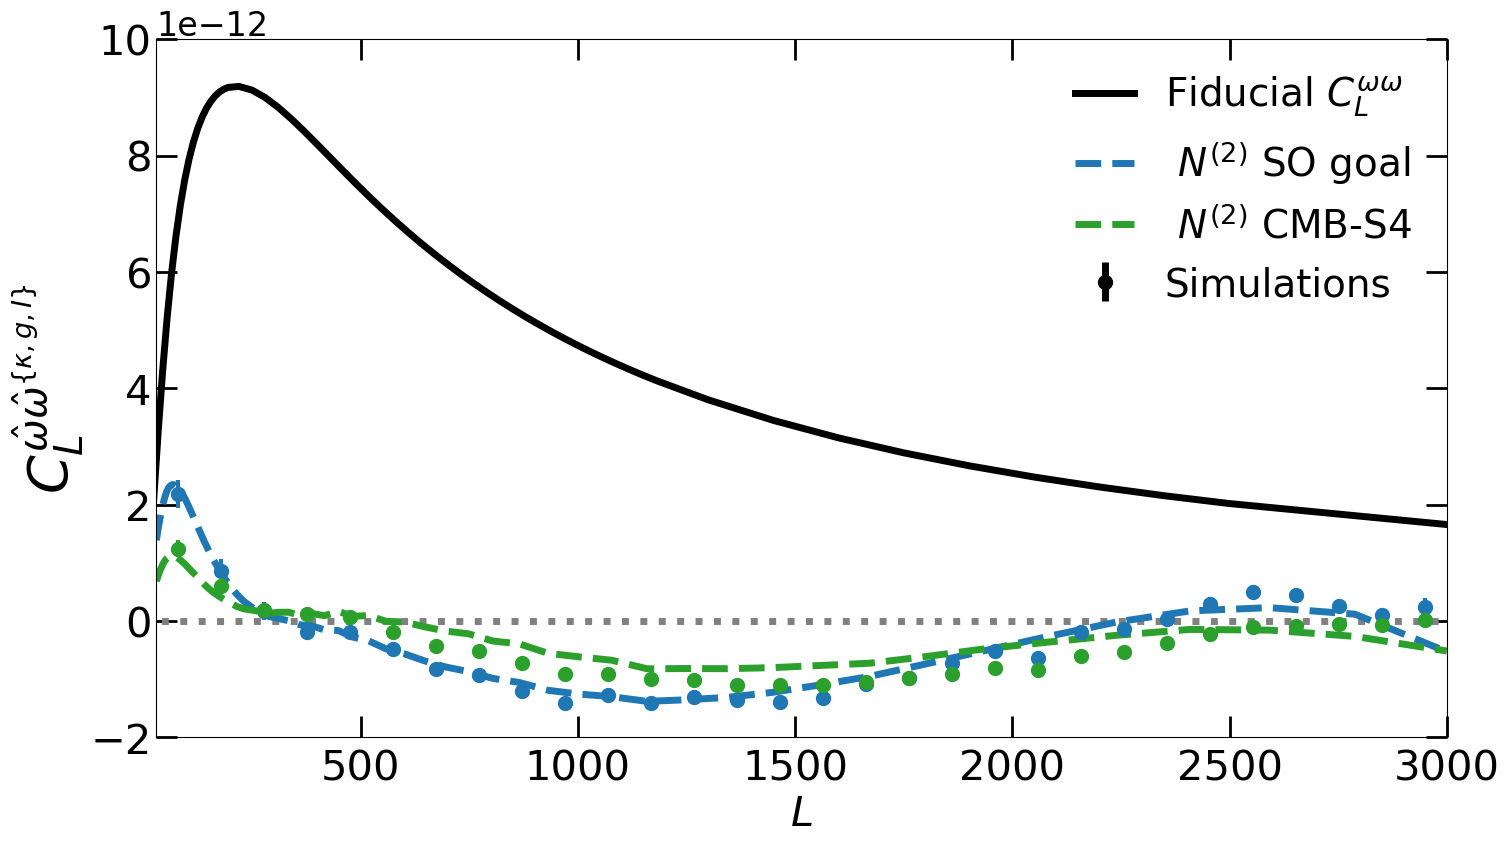

In [17]:

fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax.plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax.plot(Ls_SOg, N_SOg, color=exps.get_colour("SO_goal"), label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")
ax.plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4", linewidth=5, linestyle="--")


ax.errorbar(ks_SO, ps_SO/((2 * np.pi)**2 ) , err_SO/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax.plot(ks_SO, ps_SO/((2 * np.pi)**2 ) , ".", color=exps.get_colour("SO_goal"), markersize=20)


ax.errorbar(ks_S4, ps_S4/((2 * np.pi)**2 ) , err_S4/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax.plot(ks_S4, ps_S4/((2 * np.pi)**2 ) , ".", color=exps.get_colour("S4_base"), markersize=20)

ax.errorbar([-1],[-1], [1], color="k", label="Simulations", ls='none', fmt=".", markersize=20, linewidth=5)

ax.set_xlim(3e1,3e3)
ax.set_ylim(-2e-12,1e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 28}, frameon=False, handlelength=1.5)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results_sim.pdf", bbox_inches='tight')
plt.show()

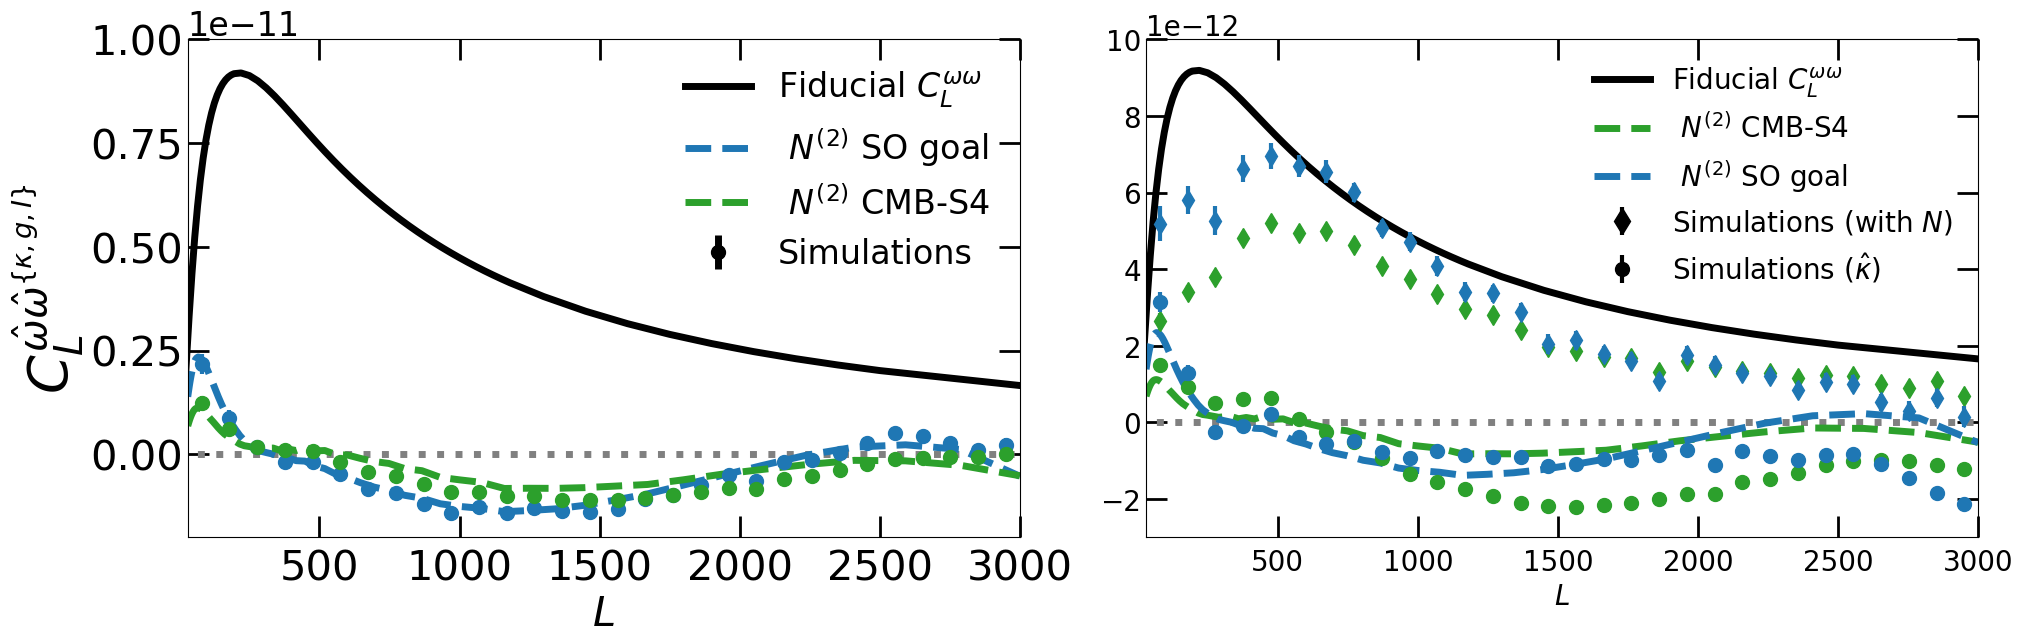

In [18]:
plt.rcParams['figure.figsize'] = [20, 7]
fig, ax = plt.subplots(1,2)
fig.tight_layout(pad=6)

ax[0].plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax[0].plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax[0].plot(Ls_SOg, N_SOg, color=exps.get_colour("SO_goal"), label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")
ax[0].plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4", linewidth=5, linestyle="--")


ax[0].errorbar(ks_SO, ps_SO/((2 * np.pi)**2 ) , err_SO/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax[0].plot(ks_SO, ps_SO/((2 * np.pi)**2 ) , ".", color=exps.get_colour("SO_goal"), markersize=20)


ax[0].errorbar(ks_S4, ps_S4/((2 * np.pi)**2 ) , err_S4/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax[0].plot(ks_S4, ps_S4/((2 * np.pi)**2 ) , ".", color=exps.get_colour("S4_base"), markersize=20)

ax[0].errorbar([-1],[-1], [1], color="k", label="Simulations", ls='none', fmt=".", markersize=20, linewidth=5)

ax[0].set_xlim(3e1,3e3)
ax[0].set_ylim(-2e-12,1e-11)
ax[0].yaxis.get_offset_text().set_fontsize(24)
ax[0].legend(prop={'size': 24}, frameon=False)
ax[0].set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax[0].set_xlabel("$L$", fontsize=30)
ax[0].tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax[0].tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax[0].tick_params(labelsize=30)

ps_S4_wN, ks_S4_wN, err_S4_wN = get_ps(f"{results_dir}/simbias_results/kgI/S4_base/gmv/TEB/12_14/30_3000/100/kappa_rec_wN",30)
ps_SO_wN, ks_SO_wN, err_SO_wN = get_ps(f"{results_dir}/simbias_results/kgI/SO_goal/gmv/TEB/12_14/30_3000/100/kappa_rec_wN",30)

ps_S4_k, ks_S4_k, err_S4_k = get_ps(f"{results_dir}/simbias_results/kgI/S4_base/gmv/TEB/12_14/30_3000/100/kappa_rec",30)
ps_SO_k, ks_SO_k, err_SO_k = get_ps(f"{results_dir}/simbias_results/kgI/SO_goal/gmv/TEB/12_14/30_3000/100/kappa_rec",30)

ax[1].plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax[1].plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax[1].plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4", linewidth=5, linestyle="--")
ax[1].plot(Ls_SOg, N_SOg, color=exps.get_colour("SO_goal"), label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")

ax[1].errorbar(ks_S4_wN, ps_S4_wN/((2 * np.pi)**2 ) , err_S4_wN/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax[1].plot(ks_S4_wN, ps_S4_wN/((2 * np.pi)**2 ) , "d", color=exps.get_colour("S4_base"), markersize=10)

ax[1].errorbar(ks_S4_k, ps_S4_k/((2 * np.pi)**2 ) , err_S4_k/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax[1].plot(ks_S4_k, ps_S4_k/((2 * np.pi)**2 ) , ".", color=exps.get_colour("S4_base"), markersize=20)


ax[1].errorbar(ks_SO_wN, ps_SO_wN/((2 * np.pi)**2 ) , err_SO_wN/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax[1].plot(ks_SO_wN, ps_SO_wN/((2 * np.pi)**2 ) , "d", color=exps.get_colour("SO_goal"), markersize=10)

ax[1].errorbar(ks_SO_k, ps_SO_k/((2 * np.pi)**2 ) , err_SO_k/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax[1].plot(ks_SO_k, ps_SO_k/((2 * np.pi)**2 ) , ".", color=exps.get_colour("SO_goal"), markersize=20)


ax[1].errorbar([-1],[-1], [1], color="k", label="Simulations (with $N$)", ls='none', fmt="d", markersize=13, linewidth=3)
ax[1].errorbar([-1],[-1], [1], color="k", label="Simulations ($\hat{\kappa}$)", ls='none', fmt=".", markersize=20, linewidth=3)


ax[1].set_xlim(3e1,3e3)
ax[1].set_ylim(-3e-12,1e-11)
ax[1].yaxis.get_offset_text().set_fontsize(20)
ax[1].legend(prop={'size': 20}, frameon=False)
ax[1].set_xlabel("$L$", fontsize=20)
ax[1].tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax[1].tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax[1].tick_params(labelsize=20)

# fig.savefig("_report_plots/bias_results_sim_both.pdf", bbox_inches='tight')
plt.show()

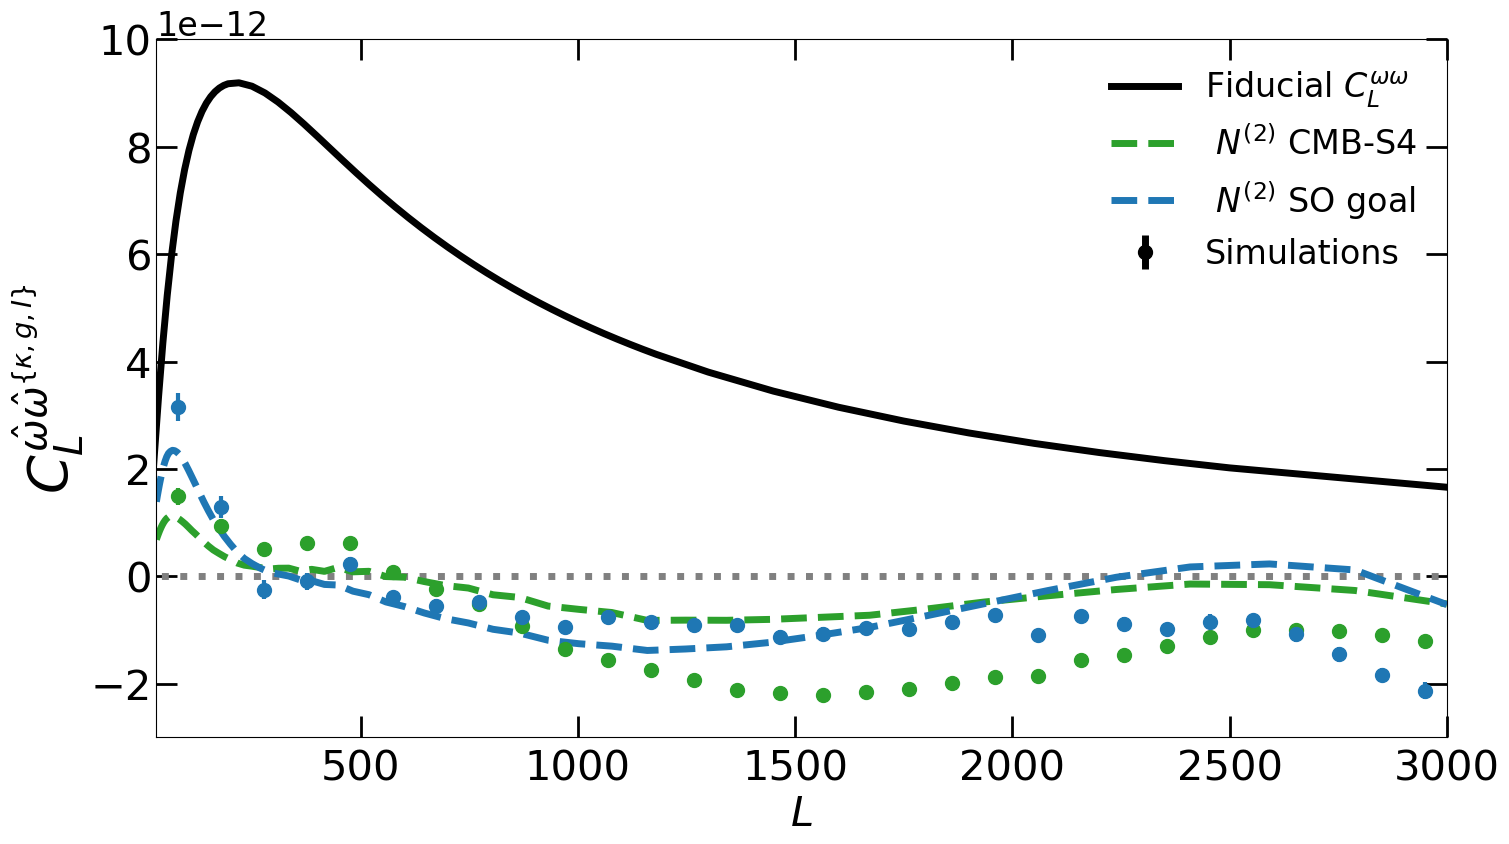

In [19]:
plt.rcParams['figure.figsize'] = [15, 9]
fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax.plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax.plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4", linewidth=5, linestyle="--")
ax.plot(Ls_SOg, N_SOg, color=exps.get_colour("SO_goal"), label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")

ax.errorbar(ks_S4_k, ps_S4_k/((2 * np.pi)**2 ) , err_S4_k/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax.plot(ks_S4_k, ps_S4_k/((2 * np.pi)**2 ) , ".", color=exps.get_colour("S4_base"), markersize=20)

ax.errorbar(ks_SO_k, ps_SO_k/((2 * np.pi)**2 ) , err_SO_k/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax.plot(ks_SO_k, ps_SO_k/((2 * np.pi)**2 ) , ".", color=exps.get_colour("SO_goal"), markersize=20)


ax.errorbar([-1],[-1], [1], color="k", label="Simulations", ls='none', fmt=".", markersize=20, linewidth=5)

ax.set_xlim(3e1,3e3)
ax.set_ylim(-3e-12,1e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 24}, frameon=False)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results.pdf", bbox_inches='tight')
plt.show()

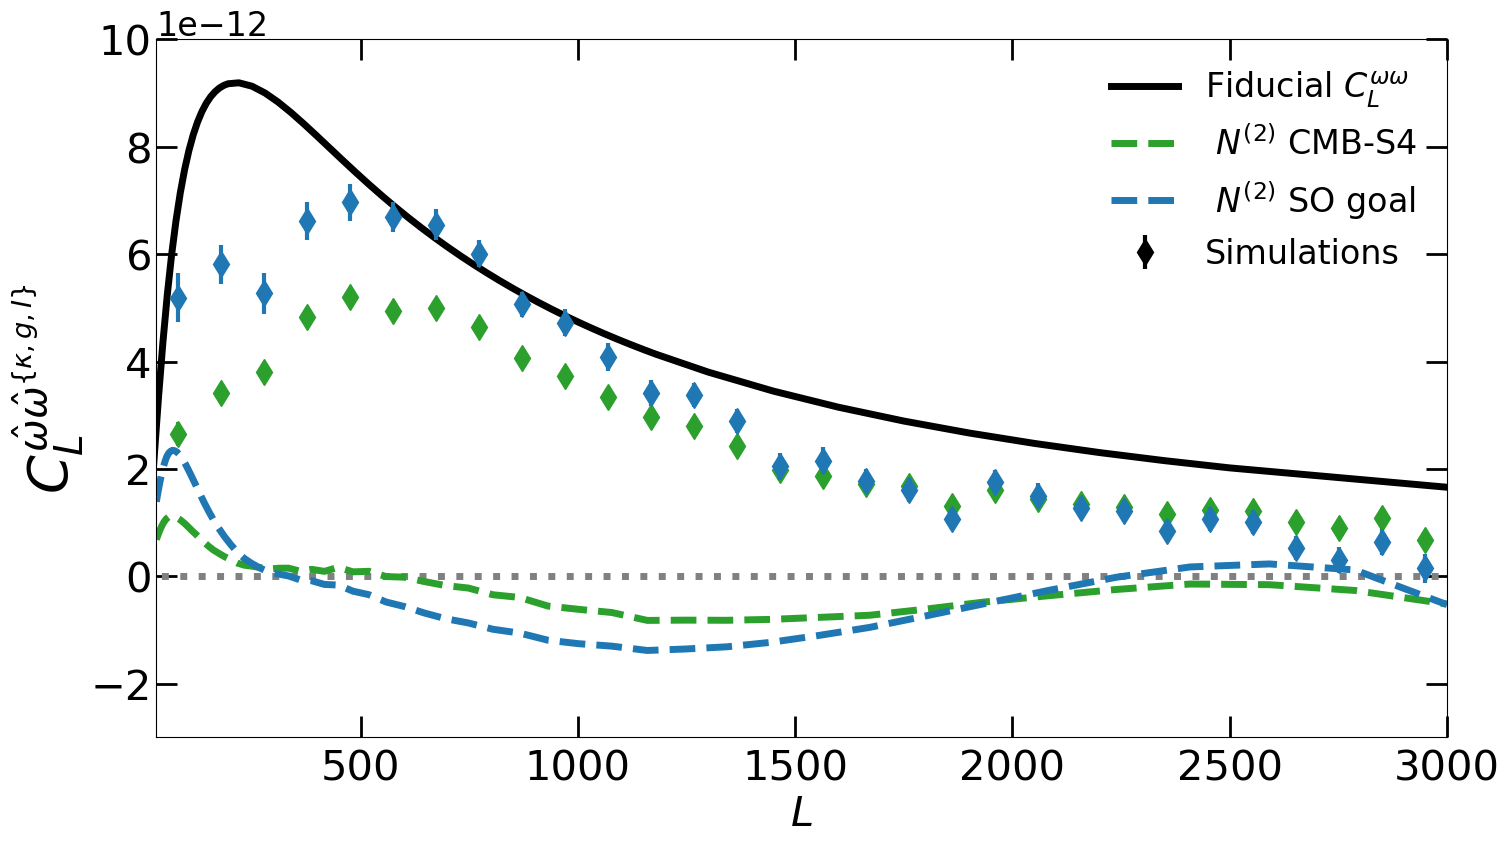

In [20]:

fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax.plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax.plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4", linewidth=5, linestyle="--")
ax.plot(Ls_SOg, N_SOg, color=exps.get_colour("SO_goal"), label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")

ax.errorbar(ks_S4_wN, ps_S4_wN/((2 * np.pi)**2 ) , err_S4_wN/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax.plot(ks_S4_wN, ps_S4_wN/((2 * np.pi)**2 ) , "d", color=exps.get_colour("S4_base"), markersize=13)

ax.errorbar(ks_SO_wN, ps_SO_wN/((2 * np.pi)**2 ) , err_SO_wN/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax.plot(ks_SO_wN, ps_SO_wN/((2 * np.pi)**2 ) , "d", color=exps.get_colour("SO_goal"), markersize=13)


ax.errorbar([-1],[-1], [1], color="k", label="Simulations", ls='none', fmt="d", markersize=13, linewidth=3)

ax.set_xlim(3e1,3e3)
ax.set_ylim(-3e-12,1e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 24}, frameon=False)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results.pdf", bbox_inches='tight')
plt.show()

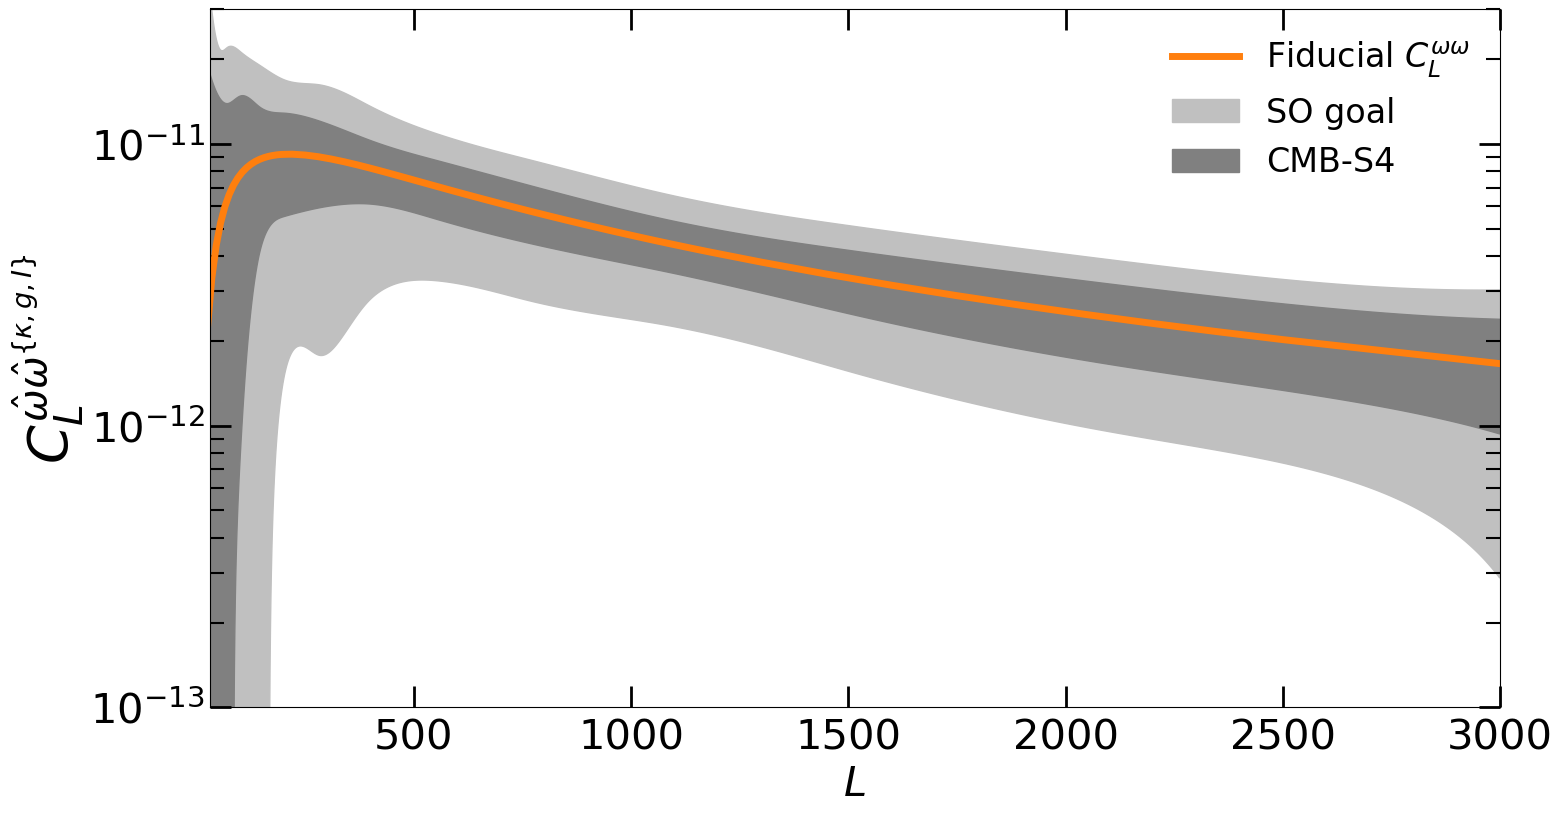

In [23]:
ps_S4_wN, ks_S4_wN, err_S4_wN = get_ps(f"{results_dir}/simbias_results/kgI/S4_base/gmv/TEB/12_14/30_3000/100/kappa_rec_wN",Ls_sig)
ps_SO_wN, ks_SO_wN, err_SO_wN = get_ps(f"{results_dir}/simbias_results/kgI/SO_goal/gmv/TEB/12_14/30_3000/100/kappa_rec_wN",Ls_sig)

C_omega_spline = InterpolatedUnivariateSpline(omega_Ls, my_omega_ps) 

err_S4_wN*=np.sqrt(100) / (np.sqrt(0.4))
err_SO_wN*=np.sqrt(100) / (np.sqrt(0.4))

ps_S4_wN =  (2 * np.pi)**2 * C_omega_spline(ks_S4_wN)
ps_SO_wN =  (2 * np.pi)**2 * C_omega_spline(ks_SO_wN)

fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color=u'#ff7f0e', linewidth=5)

Ls = np.arange(30,3000)
err_spline = InterpolatedUnivariateSpline(ks_SO_wN,err_SO_wN)
ax.plot(Ls, C_omega_spline(Ls)+(err_spline(Ls))/((2 * np.pi)**2 ), linewidth=5, linestyle="--", alpha=0)
ax.semilogy(Ls, C_omega_spline(Ls)-(err_spline(Ls))/((2 * np.pi)**2 ), linewidth=5, linestyle="--", alpha=0)
ax.fill_between(Ls, omega_ps_spline(Ls)+(err_spline(Ls))/((2 * np.pi)**2 ),omega_ps_spline(Ls)-(err_spline(Ls))/((2 * np.pi)**2 ), color="silver", alpha=1, label="SO goal")


Ls = np.arange(30,3000)
err_spline = InterpolatedUnivariateSpline(ks_S4_wN,err_S4_wN)
ax.plot(Ls, C_omega_spline(Ls)+(err_spline(Ls))/((2 * np.pi)**2 ), linewidth=5, linestyle="--", alpha=0)
ax.semilogy(Ls, C_omega_spline(Ls)-(err_spline(Ls))/((2 * np.pi)**2 ), linewidth=5, linestyle="--", alpha=0)
ax.fill_between(Ls, omega_ps_spline(Ls)+(err_spline(Ls))/((2 * np.pi)**2 ),omega_ps_spline(Ls)-(err_spline(Ls))/((2 * np.pi)**2 ), color="grey", alpha=1, label="CMB-S4")

ax.set_xlim(3e1,3e3)
ax.set_ylim(1e-13,3e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 24}, frameon=False)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results.pdf", bbox_inches='tight')
plt.show()

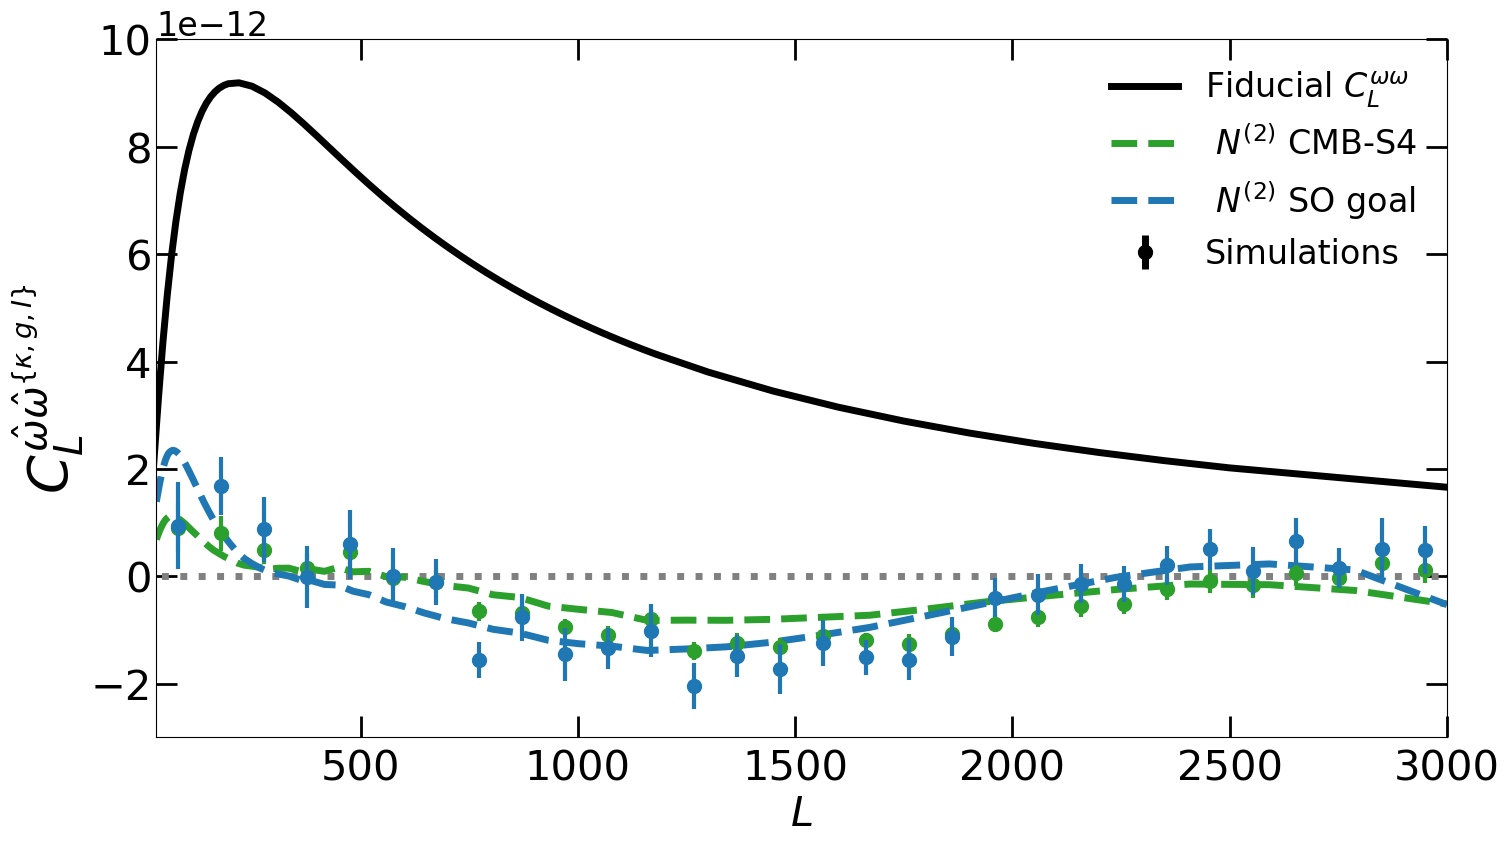

In [24]:
ps_S4_wN, ks_S4_wN, err_S4_wN = get_ps(f"{results_dir}/simbias_results/kgI/S4_base/gmv/TEB/12_14/30_3000/30/_wN",30)
ps_SO_wN, ks_SO_wN, err_SO_wN = get_ps(f"{results_dir}/simbias_results/kgI/SO_goal/gmv/TEB/12_14/30_3000/30/_wN",30)




fig, ax = plt.subplots(1,1)
fig.tight_layout(pad=6)

ax.plot([0,3000],[0,0], linestyle=":", color="grey", linewidth=5)


ax.plot(omega_Ls, my_omega_ps, label="Fiducial $C_{L}^{\omega\omega}$", color="k", linewidth=5)
ax.plot(Ls_S4, N_S4, color=exps.get_colour("S4_base"), label=" $N^{(2)}$ CMB-S4", linewidth=5, linestyle="--")
ax.plot(Ls_SOg, N_SOg, color=exps.get_colour("SO_goal"), label=" $N^{(2)}$ SO goal", linewidth=5, linestyle="--")

ax.errorbar(ks_S4_wN, ps_S4_wN/((2 * np.pi)**2 ) , err_S4_wN/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("S4_base"), linewidth=3)
ax.plot(ks_S4_wN, ps_S4_wN/((2 * np.pi)**2 ) , ".", color=exps.get_colour("S4_base"), markersize=20)

ax.errorbar(ks_SO_wN, ps_SO_wN/((2 * np.pi)**2 ) , err_SO_wN/((2 * np.pi)**2 ),fmt = " ", color=exps.get_colour("SO_goal"), linewidth=3)
ax.plot(ks_SO_wN, ps_SO_wN/((2 * np.pi)**2 ) , ".", color=exps.get_colour("SO_goal"), markersize=20)


ax.errorbar([-1],[-1], [1], color="k", label="Simulations", ls='none', fmt=".", markersize=20, linewidth=5)

ax.set_xlim(3e1,3e3)
ax.set_ylim(-3e-12,1e-11)
ax.yaxis.get_offset_text().set_fontsize(24)
ax.legend(prop={'size': 24}, frameon=False)
ax.set_ylabel("$C_{L}^{\hat{\omega}\hat{\omega}^{\{\kappa,g,I\}}}}$", fontsize=40)
ax.set_xlabel("$L$", fontsize=30)
ax.tick_params(top=True, right=True, direction="in", which="minor", length=10, width=1.5)
ax.tick_params(top=True, right=True, direction="in", which="major", length=15, width=2)
ax.tick_params(labelsize=30)

# fig.savefig("_report_plots/bias_results.pdf", bbox_inches='tight')
plt.show()